## Imports

In [ ]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libglew-dev is already the newest version (2.2.0-4).
libgl1-mesa-dev is already the newest version (23.2.1-1ubuntu3.1~22.04.2).
libosmesa6-dev is already the newest version (23.2.1-1ubuntu3.1~22.04.2).
software-properties-common is already the newest version (0.99.22.9).
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
patchelf is already the newest version (0.14.3-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!pip install free-mujoco-py==2.1.4

In [ ]:
!pip install Pillow==7.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.1/39.1 MB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Pillow: filename=Pillow-7.2.0-cp310-cp310-linux_x86_64.whl size=1140118 sha256=de92827a768d87c05ad86af5ee6b4ab98a1f1d9501d4595e0800618ca4796ff3
  Stored in directory: /root/.cache/pip/wheels/fd/5c/a6/0ab3157e7e4a0ba139bd89cb1edbe0f87876cf55ef31b05d6a
Successfully built Pillow
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.14 requires pillow>=9.0.0, but you have pillow 7.2.0 which is incompatible.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 7.2.0 which is incompatible.


In [ ]:
!pip install gym==0.15.7
!pip install torch
!pip install wandb
!pip install PyVirtualDisplay==0.2.5
!pip install gymnasium[mujoco]

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import wandb
import math
import mujoco_py
from torch import Tensor

##Utils

### init_py

In [ ]:
import sys
import os
outer_path = os.path.abspath(os.path.dirname(os.getcwd()))
sys.path.append(outer_path)

###Ant


In [ ]:
mujoco_py.get_version()

'2.0.2.13'

In [ ]:
"""Wrapper for creating the ant environment in gym_mujoco."""

from gym import utils
from gym.envs.mujoco import mujoco_env


def q_inv(a):
    return [a[0], -a[1], -a[2], -a[3]]


def q_mult(a, b):  # multiply two quaternion
    w = a[0] * b[0] - a[1] * b[1] - a[2] * b[2] - a[3] * b[3]
    i = a[0] * b[1] + a[1] * b[0] + a[2] * b[3] - a[3] * b[2]
    j = a[0] * b[2] - a[1] * b[3] + a[2] * b[0] + a[3] * b[1]
    k = a[0] * b[3] + a[1] * b[2] - a[2] * b[1] + a[3] * b[0]
    return [w, i, j, k]


class AntEnv(mujoco_env.MujocoEnv, utils.EzPickle):
    FILE = "ant.xml"
    ORI_IND = 3

    def __init__(self, file_path=None, expose_all_qpos=True,
                 expose_body_coms=None, expose_body_comvels=None):
        self._expose_all_qpos = expose_all_qpos
        self._expose_body_coms = expose_body_coms
        self._expose_body_comvels = expose_body_comvels
        file_path = '/content/ant.xml'
        self._body_com_indices = {}
        self._body_comvel_indices = {}

        mujoco_env.MujocoEnv.__init__(self, file_path, 5)
        utils.EzPickle.__init__(self)

    @property
    def physics(self):
        # check mujoco version is greater than version 1.50 to call correct physics
        # model containing PyMjData object for getting and setting position/velocity
        # check https://github.com/openai/mujoco-py/issues/80 for updates to api
        if mujoco_py.get_version() >= '1.50':
            return self.sim
        else:
            return self.model

    def _step(self, a):
        return self.step(a)

    def step(self, a):
        xposbefore = self.get_body_com("torso")[0]
        self.do_simulation(a, self.frame_skip)
        xposafter = self.get_body_com("torso")[0]
        forward_reward = (xposafter - xposbefore) / self.dt
        ctrl_cost = .5 * np.square(a).sum()
        survive_reward = 1.0
        reward = forward_reward - ctrl_cost + survive_reward
        state = self.state_vector()
        done = False
        ob = self._get_obs()
        return ob, reward, done, dict(
            reward_forward=forward_reward,
            reward_ctrl=-ctrl_cost,
            reward_survive=survive_reward)

    def _get_obs(self):
        # No cfrc observation
        if self._expose_all_qpos:
            obs = np.concatenate([
                self.physics.data.qpos.flat[:15],  # Ensures only ant obs.
                self.physics.data.qvel.flat[:14],
            ])
        else:
            obs = np.concatenate([
                self.physics.data.qpos.flat[2:15],
                self.physics.data.qvel.flat[:14],
            ])

        if self._expose_body_coms is not None:
            for name in self._expose_body_coms:
                com = self.get_body_com(name)
                if name not in self._body_com_indices:
                    indices = range(len(obs), len(obs) + len(com))
                    self._body_com_indices[name] = indices
                obs = np.concatenate([obs, com])

        if self._expose_body_comvels is not None:
            for name in self._expose_body_comvels:
                comvel = self.get_body_comvel(name)
                if name not in self._body_comvel_indices:
                    indices = range(len(obs), len(obs) + len(comvel))
                    self._body_comvel_indices[name] = indices
                obs = np.concatenate([obs, comvel])
        return obs

    def reset_model(self):
        qpos = self.init_qpos + self.np_random.uniform(
            size=self.model.nq, low=-.1, high=.1)
        qvel = self.init_qvel + self.np_random.randn(self.model.nv) * .1

        # Set everything other than ant to original position and 0 velocity.
        qpos[15:] = self.init_qpos[15:]
        qvel[14:] = 0.
        self.set_state(qpos, qvel)
        return self._get_obs()

    def viewer_setup(self):
        self.viewer.cam.distance = self.model.stat.extent * 0.5

    def get_ori(self):
        ori = [0, 1, 0, 0]
        rot = self.physics.data.qpos[self.__class__.ORI_IND:self.__class__.ORI_IND + 4]  # take the quaternion
        ori = q_mult(q_mult(rot, ori), q_inv(rot))[1:3]  # project onto x-y plane
        ori = math.atan2(ori[1], ori[0])
        return ori

    def set_xy(self, xy):
        qpos = np.copy(self.physics.data.qpos)
        qpos[0] = xy[0]
        qpos[1] = xy[1]

        qvel = self.physics.data.qvel
        self.set_state(qpos, qvel)

    def get_xy(self):
        return self.physics.data.qpos[:2]

###Maze_Env_Utils

In [ ]:
"""Adapted from rllab maze_env_utils.py."""

class Move(object):
    X = 11
    Y = 12
    Z = 13
    XY = 14
    XZ = 15
    YZ = 16
    XYZ = 17
    SpinXY = 18


def can_move_x(movable):
    return movable in [Move.X, Move.XY, Move.XZ, Move.XYZ,
                       Move.SpinXY]


def can_move_y(movable):
    return movable in [Move.Y, Move.XY, Move.YZ, Move.XYZ,
                       Move.SpinXY]


def can_move_z(movable):
    return movable in [Move.Z, Move.XZ, Move.YZ, Move.XYZ]


def can_spin(movable):
    return movable in [Move.SpinXY]


def can_move(movable):
    return can_move_x(movable) or can_move_y(movable) or can_move_z(movable)


def construct_maze(maze_id='Maze'):
    if maze_id == 'Maze':
        structure = [
            [1, 1, 1, 1, 1],
            [1, 'r', 0, 0, 1],
            [1, 1, 1, 0, 1],
            [1, 0, 0, 0, 1],
            [1, 1, 1, 1, 1],
        ]
    elif maze_id == 'Push':
        structure = [
            [1, 1, 1, 1, 1],
            [1, 0, 'r', 1, 1],
            [1, 0, Move.XY, 0, 1],
            [1, 1, 0, 1, 1],
            [1, 1, 1, 1, 1],
        ]
    elif maze_id == 'Fall':
        structure = [
            [1, 1, 1, 1],
            [1, 'r', 0, 1],
            [1, 0, Move.YZ, 1],
            [1, -1, -1, 1],
            [1, 0, 0, 1],
            [1, 1, 1, 1],
        ]
    elif maze_id == 'Block':
        O = 'r'
        structure = [
            [1, 1, 1, 1, 1],
            [1, O, 0, 0, 1],
            [1, 0, 0, 0, 1],
            [1, 0, 0, 0, 1],
            [1, 1, 1, 1, 1],
        ]
    elif maze_id == 'BlockMaze':
        O = 'r'
        structure = [
            [1, 1, 1, 1],
            [1, O, 0, 1],
            [1, 1, 0, 1],
            [1, 0, 0, 1],
            [1, 1, 1, 1],
        ]
    else:
        raise NotImplementedError('The provided MazeId %s is not recognized' % maze_id)

    return structure


def line_intersect(pt1, pt2, ptA, ptB):
    """
  Taken from https://www.cs.hmc.edu/ACM/lectures/intersections.html
  this returns the intersection of Line(pt1,pt2) and Line(ptA,ptB)
  """

    DET_TOLERANCE = 0.00000001

    # the first line is pt1 + r*(pt2-pt1)
    # in component form:
    x1, y1 = pt1
    x2, y2 = pt2
    dx1 = x2 - x1
    dy1 = y2 - y1

    # the second line is ptA + s*(ptB-ptA)
    x, y = ptA
    xB, yB = ptB
    dx = xB - x
    dy = yB - y

    DET = (-dx1 * dy + dy1 * dx)

    if math.fabs(DET) < DET_TOLERANCE: return (0, 0, 0, 0, 0)

    # now, the determinant should be OK
    DETinv = 1.0 / DET

    # find the scalar amount along the "self" segment
    r = DETinv * (-dy * (x - x1) + dx * (y - y1))

    # find the scalar amount along the input line
    s = DETinv * (-dy1 * (x - x1) + dx1 * (y - y1))

    # return the average of the two descriptions
    xi = (x1 + r * dx1 + x + s * dx) / 2.0
    yi = (y1 + r * dy1 + y + s * dy) / 2.0
    return (xi, yi, 1, r, s)


def ray_segment_intersect(ray, segment):
    """
  Check if the ray originated from (x, y) with direction theta intersects the line segment (x1, y1) -- (x2, y2),
  and return the intersection point if there is one
  """
    (x, y), theta = ray
    # (x1, y1), (x2, y2) = segment
    pt1 = (x, y)
    len = 1
    pt2 = (x + len * math.cos(theta), y + len * math.sin(theta))
    xo, yo, valid, r, s = line_intersect(pt1, pt2, *segment)
    if valid and r >= 0 and 0 <= s <= 1:
        return (xo, yo)
    return None


def point_distance(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

###Maze_Env

In [ ]:
"""Adapted from rllab maze_env.py."""

import os
import tempfile
import xml.etree.ElementTree as ET

# Directory that contains mujoco xml files.
MODEL_DIR = '/content'


class MazeEnv(gym.Env):
    MODEL_CLASS = None

    MAZE_HEIGHT = None
    MAZE_SIZE_SCALING = None

    def __init__(
            self,
            maze_id=None,
            maze_height=0.5,
            maze_size_scaling=8,
            n_bins=0,
            sensor_range=3.,
            sensor_span=2 * math.pi,
            observe_blocks=False,
            put_spin_near_agent=False,
            top_down_view=False,
            manual_collision=False,
            *args,
            **kwargs):
        self._maze_id = maze_id

        model_cls = self.__class__.MODEL_CLASS
        if model_cls is None:
            raise Exception("MODEL_CLASS unspecified!")
        proj_name = "impl_hiro"
        proj_path = os.getcwd()
        proj_path = os.path.join(proj_path.split("/"+proj_name)[0], proj_name)
        xml_path = os.path.join(proj_path, MODEL_DIR, model_cls.FILE)
        tree = ET.parse(xml_path)
        worldbody = tree.find(".//worldbody")

        self.MAZE_HEIGHT = height = maze_height
        self.MAZE_SIZE_SCALING = size_scaling = maze_size_scaling
        self._n_bins = n_bins
        self._sensor_range = sensor_range * size_scaling
        self._sensor_span = sensor_span
        self._observe_blocks = observe_blocks
        self._put_spin_near_agent = put_spin_near_agent
        self._top_down_view = top_down_view
        self._manual_collision = manual_collision

        self.MAZE_STRUCTURE = structure = construct_maze(maze_id=self._maze_id)
        self.elevated = any(-1 in row for row in structure)  # Elevate the maze to allow for falling.
        self.blocks = any(
            any(can_move(r) for r in row)
            for row in structure)  # Are there any movable blocks?

        torso_x, torso_y = self._find_robot()
        self._init_torso_x = torso_x
        self._init_torso_y = torso_y
        self._init_positions = [
            (x - torso_x, y - torso_y)
            for x, y in self._find_all_robots()]

        self._xy_to_rowcol = lambda x, y: (2 + (y + size_scaling / 2) / size_scaling,
                                           2 + (x + size_scaling / 2) / size_scaling)
        self._view = np.zeros([5, 5, 3])  # walls (immovable), chasms (fall), movable blocks

        height_offset = 0.
        if self.elevated:
            # Increase initial z-pos of ant.
            height_offset = height * size_scaling
            torso = tree.find(".//body[@name='torso']")
            torso.set('pos', '0 0 %.2f' % (0.75 + height_offset))
        if self.blocks:
            # If there are movable blocks, change simulation settings to perform
            # better contact detection.
            default = tree.find(".//default")
            default.find('.//geom').set('solimp', '.995 .995 .01')

        self.movable_blocks = []
        for i in range(len(structure)):
            for j in range(len(structure[0])):
                struct = structure[i][j]
                if struct == 'r' and self._put_spin_near_agent:
                    struct = Move.SpinXY
                if self.elevated and struct not in [-1]:
                    # Create elevated platform.
                    ET.SubElement(
                        worldbody, "geom",
                        name="elevated_%d_%d" % (i, j),
                        pos="%f %f %f" % (j * size_scaling - torso_x,
                                          i * size_scaling - torso_y,
                                          height / 2 * size_scaling),
                        size="%f %f %f" % (0.5 * size_scaling,
                                           0.5 * size_scaling,
                                           height / 2 * size_scaling),
                        type="box",
                        material="",
                        contype="1",
                        conaffinity="1",
                        rgba="0.9 0.9 0.9 1",
                    )
                if struct == 1:  # Unmovable block.
                    # Offset all coordinates so that robot starts at the origin.
                    ET.SubElement(
                        worldbody, "geom",
                        name="block_%d_%d" % (i, j),
                        pos="%f %f %f" % (j * size_scaling - torso_x,
                                          i * size_scaling - torso_y,
                                          height_offset +
                                          height / 2 * size_scaling),
                        size="%f %f %f" % (0.5 * size_scaling,
                                           0.5 * size_scaling,
                                           height / 2 * size_scaling),
                        type="box",
                        material="",
                        contype="1",
                        conaffinity="1",
                        rgba="0.4 0.4 0.4 1",
                    )
                elif can_move(struct):  # Movable block.
                    # The "falling" blocks are shrunk slightly and increased in mass to
                    # ensure that it can fall easily through a gap in the platform blocks.
                    name = "movable_%d_%d" % (i, j)
                    self.movable_blocks.append((name, struct))
                    falling = can_move_z(struct)
                    spinning = can_spin(struct)
                    x_offset = 0.25 * size_scaling if spinning else 0.0
                    y_offset = 0.0
                    shrink = 0.1 if spinning else 0.99 if falling else 1.0
                    height_shrink = 0.1 if spinning else 1.0
                    movable_body = ET.SubElement(
                        worldbody, "body",
                        name=name,
                        pos="%f %f %f" % (j * size_scaling - torso_x + x_offset,
                                          i * size_scaling - torso_y + y_offset,
                                          height_offset +
                                          height / 2 * size_scaling * height_shrink),
                    )
                    ET.SubElement(
                        movable_body, "geom",
                        name="block_%d_%d" % (i, j),
                        pos="0 0 0",
                        size="%f %f %f" % (0.5 * size_scaling * shrink,
                                           0.5 * size_scaling * shrink,
                                           height / 2 * size_scaling * height_shrink),
                        type="box",
                        material="",
                        mass="0.001" if falling else "0.0002",
                        contype="1",
                        conaffinity="1",
                        rgba="0.9 0.1 0.1 1"
                    )
                    if can_move_x(struct):
                        ET.SubElement(
                            movable_body, "joint",
                            armature="0",
                            axis="1 0 0",
                            damping="0.0",
                            limited="true" if falling else "false",
                            range="%f %f" % (-size_scaling, size_scaling),
                            margin="0.01",
                            name="movable_x_%d_%d" % (i, j),
                            pos="0 0 0",
                            type="slide"
                        )
                    if can_move_y(struct):
                        ET.SubElement(
                            movable_body, "joint",
                            armature="0",
                            axis="0 1 0",
                            damping="0.0",
                            limited="true" if falling else "false",
                            range="%f %f" % (-size_scaling, size_scaling),
                            margin="0.01",
                            name="movable_y_%d_%d" % (i, j),
                            pos="0 0 0",
                            type="slide"
                        )
                    if can_move_z(struct):
                        ET.SubElement(
                            movable_body, "joint",
                            armature="0",
                            axis="0 0 1",
                            damping="0.0",
                            limited="true",
                            range="%f 0" % (-height_offset),
                            margin="0.01",
                            name="movable_z_%d_%d" % (i, j),
                            pos="0 0 0",
                            type="slide"
                        )
                    if can_spin(struct):
                        ET.SubElement(
                            movable_body, "joint",
                            armature="0",
                            axis="0 0 1",
                            damping="0.0",
                            limited="false",
                            name="spinable_%d_%d" % (i, j),
                            pos="0 0 0",
                            type="ball"
                        )

        torso = tree.find(".//body[@name='torso']")
        geoms = torso.findall(".//geom")
        for geom in geoms:
            if 'name' not in geom.attrib:
                raise Exception("Every geom of the torso must have a name "
                                "defined")

        _, file_path = tempfile.mkstemp(text=True, suffix='.xml')
        tree.write(file_path)

        self.wrapped_env = model_cls(*args, file_path=file_path, **kwargs)

    def get_ori(self):
        return self.wrapped_env.get_ori()

    def get_top_down_view(self):
        self._view = np.zeros_like(self._view)

        def valid(row, col):
            return self._view.shape[0] > row >= 0 and self._view.shape[1] > col >= 0

        def update_view(x, y, d, row=None, col=None):
            if row is None or col is None:
                x = x - self._robot_x
                y = y - self._robot_y
                th = self._robot_ori

                row, col = self._xy_to_rowcol(x, y)
                update_view(x, y, d, row=row, col=col)
                return

            row, row_frac, col, col_frac = int(row), row % 1, int(col), col % 1
            if row_frac < 0:
                row_frac += 1
            if col_frac < 0:
                col_frac += 1

            if valid(row, col):
                self._view[row, col, d] += (
                        (min(1., row_frac + 0.5) - max(0., row_frac - 0.5)) *
                        (min(1., col_frac + 0.5) - max(0., col_frac - 0.5)))
            if valid(row - 1, col):
                self._view[row - 1, col, d] += (
                        (max(0., 0.5 - row_frac)) *
                        (min(1., col_frac + 0.5) - max(0., col_frac - 0.5)))
            if valid(row + 1, col):
                self._view[row + 1, col, d] += (
                        (max(0., row_frac - 0.5)) *
                        (min(1., col_frac + 0.5) - max(0., col_frac - 0.5)))
            if valid(row, col - 1):
                self._view[row, col - 1, d] += (
                        (min(1., row_frac + 0.5) - max(0., row_frac - 0.5)) *
                        (max(0., 0.5 - col_frac)))
            if valid(row, col + 1):
                self._view[row, col + 1, d] += (
                        (min(1., row_frac + 0.5) - max(0., row_frac - 0.5)) *
                        (max(0., col_frac - 0.5)))
            if valid(row - 1, col - 1):
                self._view[row - 1, col - 1, d] += (
                        (max(0., 0.5 - row_frac)) * max(0., 0.5 - col_frac))
            if valid(row - 1, col + 1):
                self._view[row - 1, col + 1, d] += (
                        (max(0., 0.5 - row_frac)) * max(0., col_frac - 0.5))
            if valid(row + 1, col + 1):
                self._view[row + 1, col + 1, d] += (
                        (max(0., row_frac - 0.5)) * max(0., col_frac - 0.5))
            if valid(row + 1, col - 1):
                self._view[row + 1, col - 1, d] += (
                        (max(0., row_frac - 0.5)) * max(0., 0.5 - col_frac))

        # Draw ant.
        robot_x, robot_y = self.wrapped_env.get_body_com("torso")[:2]
        self._robot_x = robot_x
        self._robot_y = robot_y
        self._robot_ori = self.get_ori()

        structure = self.MAZE_STRUCTURE
        size_scaling = self.MAZE_SIZE_SCALING
        height = self.MAZE_HEIGHT

        # Draw immovable blocks and chasms.
        for i in range(len(structure)):
            for j in range(len(structure[0])):
                if structure[i][j] == 1:  # Wall.
                    update_view(j * size_scaling - self._init_torso_x,
                                i * size_scaling - self._init_torso_y,
                                0)
                if structure[i][j] == -1:  # Chasm.
                    update_view(j * size_scaling - self._init_torso_x,
                                i * size_scaling - self._init_torso_y,
                                1)

        # Draw movable blocks.
        for block_name, block_type in self.movable_blocks:
            block_x, block_y = self.wrapped_env.get_body_com(block_name)[:2]
            update_view(block_x, block_y, 2)

        return self._view

    def get_range_sensor_obs(self):
        """Returns egocentric range sensor observations of maze."""
        robot_x, robot_y, robot_z = self.wrapped_env.get_body_com("torso")[:3]
        ori = self.get_ori()

        structure = self.MAZE_STRUCTURE
        size_scaling = self.MAZE_SIZE_SCALING
        height = self.MAZE_HEIGHT

        segments = []
        # Get line segments (corresponding to outer boundary) of each immovable
        # block or drop-off.
        for i in range(len(structure)):
            for j in range(len(structure[0])):
                if structure[i][j] in [1, -1]:  # There's a wall or drop-off.
                    cx = j * size_scaling - self._init_torso_x
                    cy = i * size_scaling - self._init_torso_y
                    x1 = cx - 0.5 * size_scaling
                    x2 = cx + 0.5 * size_scaling
                    y1 = cy - 0.5 * size_scaling
                    y2 = cy + 0.5 * size_scaling
                    struct_segments = [
                        ((x1, y1), (x2, y1)),
                        ((x2, y1), (x2, y2)),
                        ((x2, y2), (x1, y2)),
                        ((x1, y2), (x1, y1)),
                    ]
                    for seg in struct_segments:
                        segments.append(dict(
                            segment=seg,
                            type=structure[i][j],
                        ))
        # Get line segments (corresponding to outer boundary) of each movable
        # block within the agent's z-view.
        for block_name, block_type in self.movable_blocks:
            block_x, block_y, block_z = self.wrapped_env.get_body_com(block_name)[:3]
            if (block_z + height * size_scaling / 2 >= robot_z and
                    robot_z >= block_z - height * size_scaling / 2):  # Block in view.
                x1 = block_x - 0.5 * size_scaling
                x2 = block_x + 0.5 * size_scaling
                y1 = block_y - 0.5 * size_scaling
                y2 = block_y + 0.5 * size_scaling
                struct_segments = [
                    ((x1, y1), (x2, y1)),
                    ((x2, y1), (x2, y2)),
                    ((x2, y2), (x1, y2)),
                    ((x1, y2), (x1, y1)),
                ]
                for seg in struct_segments:
                    segments.append(dict(
                        segment=seg,
                        type=block_type,
                    ))

        sensor_readings = np.zeros((self._n_bins, 3))  # 3 for wall, drop-off, block
        for ray_idx in range(self._n_bins):
            ray_ori = (ori - self._sensor_span * 0.5 +
                       (2 * ray_idx + 1.0) / (2 * self._n_bins) * self._sensor_span)
            ray_segments = []
            # Get all segments that intersect with ray.
            for seg in segments:
                p = ray_segment_intersect(
                    ray=((robot_x, robot_y), ray_ori),
                    segment=seg["segment"])
                if p is not None:
                    ray_segments.append(dict(
                        segment=seg["segment"],
                        type=seg["type"],
                        ray_ori=ray_ori,
                        distance=point_distance(p, (robot_x, robot_y)),
                    ))
            if len(ray_segments) > 0:
                # Find out which segment is intersected first.
                first_seg = sorted(ray_segments, key=lambda x: x["distance"])[0]
                seg_type = first_seg["type"]
                idx = (0 if seg_type == 1 else  # Wall.
                       1 if seg_type == -1 else  # Drop-off.
                       2 if can_move(seg_type) else  # Block.
                       None)
                if first_seg["distance"] <= self._sensor_range:
                    sensor_readings[ray_idx][idx] = (self._sensor_range - first_seg["distance"]) / self._sensor_range

        return sensor_readings

    def _get_obs(self):
        wrapped_obs = self.wrapped_env._get_obs()
        if self._top_down_view:
            view = [self.get_top_down_view().flat]
        else:
            view = []

        if self._observe_blocks:
            additional_obs = []
            for block_name, block_type in self.movable_blocks:
                additional_obs.append(self.wrapped_env.get_body_com(block_name))
            wrapped_obs = np.concatenate([wrapped_obs[:3]] + additional_obs +
                                         [wrapped_obs[3:]])

        range_sensor_obs = self.get_range_sensor_obs()
        return np.concatenate([wrapped_obs,
                               range_sensor_obs.flat] +
                              view + [[self.t * 0.001]])

    def reset(self):
        self.t = 0
        self.trajectory = []
        self.wrapped_env.reset()
        if len(self._init_positions) > 1:
            xy = random.choice(self._init_positions)
            self.wrapped_env.set_xy(xy)
        return self._get_obs()

    @property
    def viewer(self):
        return self.wrapped_env.viewer

    def render(self, *args, **kwargs):
        return self.wrapped_env.render(*args, **kwargs)

    @property
    def observation_space(self):
        shape = self._get_obs().shape
        high = np.inf * np.ones(shape)
        low = -high
        return gym.spaces.Box(low, high)

    @property
    def action_space(self):
        return self.wrapped_env.action_space

    def _find_robot(self):
        structure = self.MAZE_STRUCTURE
        size_scaling = self.MAZE_SIZE_SCALING
        for i in range(len(structure)):
            for j in range(len(structure[0])):
                if structure[i][j] == 'r':
                    return j * size_scaling, i * size_scaling
        assert False, 'No robot in maze specification.'

    def _find_all_robots(self):
        structure = self.MAZE_STRUCTURE
        size_scaling = self.MAZE_SIZE_SCALING
        coords = []
        for i in range(len(structure)):
            for j in range(len(structure[0])):
                if structure[i][j] == 'r':
                    coords.append((j * size_scaling, i * size_scaling))
        return coords

    def _is_in_collision(self, pos):
        x, y = pos
        structure = self.MAZE_STRUCTURE
        size_scaling = self.MAZE_SIZE_SCALING
        for i in range(len(structure)):
            for j in range(len(structure[0])):
                if structure[i][j] == 1:
                    minx = j * size_scaling - size_scaling * 0.5 - self._init_torso_x
                    maxx = j * size_scaling + size_scaling * 0.5 - self._init_torso_x
                    miny = i * size_scaling - size_scaling * 0.5 - self._init_torso_y
                    maxy = i * size_scaling + size_scaling * 0.5 - self._init_torso_y
                    if minx <= x <= maxx and miny <= y <= maxy:
                        return True
        return False

    def step(self, action):
        self.t += 1
        if self._manual_collision:
            old_pos = self.wrapped_env.get_xy()
            inner_next_obs, inner_reward, done, info = self.wrapped_env.step(action)
            new_pos = self.wrapped_env.get_xy()
            if self._is_in_collision(new_pos):
                self.wrapped_env.set_xy(old_pos)
        else:
            inner_next_obs, inner_reward, done, info = self.wrapped_env.step(action)
        next_obs = self._get_obs()
        done = False
        return next_obs, inner_reward, done, info

###Ant_Maze_Env

In [ ]:
class AntMazeEnv(MazeEnv):
    MODEL_CLASS = AntEnv

### Point

In [ ]:
"""Wrapper for creating the ant environment in gym_mujoco."""

class PointEnv(mujoco_env.MujocoEnv, utils.EzPickle):
    FILE = "point.xml"
    ORI_IND = 2

    def __init__(self, file_path=None, expose_all_qpos=True):
        self._expose_all_qpos = expose_all_qpos

        mujoco_env.MujocoEnv.__init__(self, file_path, 1)
        utils.EzPickle.__init__(self)

    @property
    def physics(self):
        # check mujoco version is greater than version 1.50 to call correct physics
        # model containing PyMjData object for getting and setting position/velocity
        # check https://github.com/openai/mujoco-py/issues/80 for updates to api
        if mujoco_py.get_version() >= '1.50':
            return self.sim
        else:
            return self.model

    def _step(self, a):
        return self.step(a)

    def step(self, action):
        action[0] = 0.2 * action[0]
        qpos = np.copy(self.physics.data.qpos)
        qpos[2] += action[1]
        ori = qpos[2]
        # compute increment in each direction
        dx = math.cos(ori) * action[0]
        dy = math.sin(ori) * action[0]
        # ensure that the robot is within reasonable range
        qpos[0] = np.clip(qpos[0] + dx, -100, 100)
        qpos[1] = np.clip(qpos[1] + dy, -100, 100)
        qvel = self.physics.data.qvel
        self.set_state(qpos, qvel)
        for _ in range(0, self.frame_skip):
            self.physics.step()
        next_obs = self._get_obs()
        reward = 0
        done = False
        info = {}
        return next_obs, reward, done, info

    def _get_obs(self):
        if self._expose_all_qpos:
            return np.concatenate([
                self.physics.data.qpos.flat[:3],  # Only point-relevant coords.
                self.physics.data.qvel.flat[:3]])
        return np.concatenate([
            self.physics.data.qpos.flat[2:3],
            self.physics.data.qvel.flat[:3]])

    def reset_model(self):
        qpos = self.init_qpos + self.np_random.uniform(
            size=self.physics.model.nq, low=-.1, high=.1)
        qvel = self.init_qvel + self.np_random.randn(self.physics.model.nv) * .1

        # Set everything other than point to original position and 0 velocity.
        qpos[3:] = self.init_qpos[3:]
        qvel[3:] = 0.
        self.set_state(qpos, qvel)
        return self._get_obs()

    def get_ori(self):
        return self.physics.data.qpos[self.__class__.ORI_IND]

    def set_xy(self, xy):
        qpos = np.copy(self.physics.data.qpos)
        qpos[0] = xy[0]
        qpos[1] = xy[1]

        qvel = self.physics.data.qvel

### Point_Maze_Env

In [ ]:
class PointMazeEnv(MazeEnv):
    MODEL_CLASS = PointEnv

### Create_Maze_Env

In [ ]:
# import tensorflow as tf
# import gin.tf
# from tf_agents.environment import gym_wrapper
# from tf_agents.environment import tf_py_environment


# @gin.configurable
def create_maze_env(env_name=None, top_down_view=False):
    n_bins = 0
    manual_collision = False
    if env_name.startswith('Ego'):
        n_bins = 8
        env_name = env_name[3:]
    if env_name.startswith('Ant'):
        cls = AntMazeEnv
        env_name = env_name[3:]
        maze_size_scaling = 8
    elif env_name.startswith('Point'):
        cls = PointMazeEnv
        manual_collision = True
        env_name = env_name[5:]
        maze_size_scaling = 4
    else:
        assert False, 'unknown env %s' % env_name

    maze_id = None
    observe_blocks = False
    put_spin_near_agent = False
    if env_name == 'Maze':
        maze_id = 'Maze'
    elif env_name == 'Push':
        maze_id = 'Push'
    elif env_name == 'Fall':
        maze_id = 'Fall'
    elif env_name == 'Block':
        maze_id = 'Block'
        put_spin_near_agent = True
        observe_blocks = True
    elif env_name == 'BlockMaze':
        maze_id = 'BlockMaze'
        put_spin_near_agent = True
        observe_blocks = True
    else:
        raise ValueError('Unknown maze environment %s' % env_name)

    # def _get_obs():
    #     wrapped_obs = self.wrapped_env._get_obs()
    #     if self._top_down_view:
    #         view = [self.get_top_down_view().flat]
    #     else:
    #         view = []

    #     if self._observe_blocks:
    #         additional_obs = []
    #         for block_name, block_type in self.movable_blocks:
    #             additional_obs.append(self.wrapped_env.get_body_com(block_name))
    #         wrapped_obs = np.concatenate([wrapped_obs[:3]] + additional_obs +
    #                                      [wrapped_obs[3:]])

    #     range_sensor_obs = self.get_range_sensor_obs()
    #     return np.concatenate([wrapped_obs,
    #                            range_sensor_obs.flat] +
    #                           view + [[self.t * 0.001]])

    # def observation_space(self):
    #     shape = self._get_obs().shape
    #     high = np.inf * np.ones(shape)
    #     low = -high
    #     return gym.spaces.Box(low, high)

    gym_mujoco_kwargs = {
        'maze_id': maze_id,
        'n_bins': n_bins,
        'observe_blocks': observe_blocks,
        'put_spin_near_agent': put_spin_near_agent,
        'top_down_view': top_down_view,
        'manual_collision': manual_collision,
        'maze_size_scaling': maze_size_scaling,
        # "observation_space" : ,
    }

    gym_env = cls(**gym_mujoco_kwargs)
    gym_env.reset()
    return gym_env
    # wrapped_env = gym_wrapper.GymWrapper(gym_env)
    # return wrapped_env


# class TFPyEnvironment(tf_py_environment.TFPyEnvironment):
#     def __init__(self, *args, **kwargs):
#         super(TFPyEnvironment, self).__init__(*args, **kwargs)
#
#     def start_collect(self):
#         pass
#
#     def current_obs(self):
#         time_step = self.current_time_step()
#         return time_step.observation[0]  # For some reason, there is an extra dim.
#
#     def step(self, actions):
#         actions = tf.expand_dims(actions, 0)
#         next_step = super(TFPyEnvironment, self).step(actions)
#         return next_step.is_last()[0], next_step.reward[0], next_step.discount[0]
#
#     def reset(self):
#         return super(TFPyEnvironment, self).reset()

### Project Utils

In [ ]:
"""
Project utils
"""

# from environments.create_maze_env import create_maze_env


class ParamDict(dict):
    __setattr__ = dict.__setitem__

    def __getattr__(self, attr):
        # Take care that getattr() raises AttributeError, not KeyError.
        # Required e.g. for hasattr(), deepcopy and OrderedDict.
        try:
            return self.__getitem__(attr)
        except KeyError:
            raise AttributeError("Attribute %r not found" % attr)

    def __getstate__(self):
        return self

    def __setstate__(self, d):
        self = d


class LoggerTrigger:
    # trigger log behaviour intermittently
    def __init__(self, start_ind=1, first_log=True):
        self.last_log = int(start_ind)
        self.first_log = not first_log

    def good2log(self, t, interval):
        if int(t / interval) > int(self.last_log / interval):
            self.last_log = t
            return True
        elif not self.first_log and 0 < t - self.last_log < interval:
            self.first_log = True
            return True
        return False


class TimeLogger:
    def __init__(self):
        self.start_time = time.time()
        self.sps_start_time = time.time()
        self.sps_start_step = 0

    def sps(self, step):
        cur_time = time.time()
        time_span = cur_time - self.sps_start_time
        sps = (step - self.sps_start_step) / time_span
        self.sps_start_time = cur_time
        self.sps_start_step = step
        print("    >| state per second in past {}s: {}".format(time_span, sps))

    def time_spent(self):
        time_span = time.time() - self.start_time
        print("    >| training time: {} minutes".format(float('%.2f' % (time_span/60))))


envnames_ant = ['AntBlock', 'AntBlockMaze', 'AntFall', 'AntMaze', 'AntPush']
envnames_mujoco = ['InvertedPendulum-v2', 'InvertedDoublePendulum-v2', 'Hopper-v2',
                   'Humanoid-v2', 'Ant-v2', 'Reacher-v2', 'HalfCheetah-v2', 'Walker2d-v2']

# max_goal = [
#         10., 10., .5,  # 0-2
#         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,  # 3-13
#         30, 30, 30, 30, 30, 30, 30,  # 14-20
#         30, 30, 30, 30, 30, 30, 30, 30,  # 21-28
#         1.]  # 29


def get_env(env_name):
    global envnames_ant
    global envnames_mujoco
    if env_name in envnames_ant:
        env = create_maze_env(env_name=env_name)
    if env_name in envnames_mujoco:
        env = gym.make(env_name)
    else:
        raise NotImplementedError("environment {} is not supported!".format(env_name))
    return env


def get_target_position(env_name):
    if env_name == 'AntPush':
        target_pos = torch.Tensor([0, 19, 0.5])
    elif env_name == 'AntFall':
        target_pos = torch.Tensor([0, 27, 4.5])
    elif env_name in envnames_mujoco:
        env = gym.make(env_name)
        target_pos = torch.zeros(env.observation_space.shape[0])
    else:

        raise ValueError("{} is either wrong or not implemented!".format(env_name))
    return target_pos


def log_video(env_name, actor):
    if env_name in envnames_mujoco:
        env = gym.make(env_name)
    elif env_name in envnames_ant:
        env = create_maze_env(env_name=env_name)
    print('\n    > Collecting current trajectory...')
    done = False
    step = 1
    state = env.reset()
    frame_buffer = []
    while not done:
        frame_buffer.append(env.render(mode='rgb_array'))
        action = actor(torch.Tensor(state)).detach().cpu()
        state, reward, done, info = env.step(action)
        step += 1
    print('    > Finished collection, saved video.\n')
    frame_buffer = np.array(frame_buffer).transpose(0, 3, 1, 2)
    wandb.log({"video": wandb.Video(frame_buffer, fps=30, format="mp4")})
    env.close()


def log_video_hrl(env_name, actor_low, actor_high, params):
    actor_low = copy.deepcopy(actor_low).cpu()
    actor_high = copy.deepcopy(actor_high).cpu()
    actor_high.max_goal = actor_high.max_goal.to('cpu')
    policy_params = params.policy_params
    goal_dim = params.goal_dim
    if env_name in envnames_mujoco:
        env = gym.make(env_name)
    elif env_name in envnames_ant:
        env = create_maze_env(env_name=env_name)
    print('\n    > Collecting current trajectory...')
    done = False
    step = 1
    state = torch.Tensor(env.reset())
    goal = torch.Tensor(torch.randn(goal_dim))
    episode_reward, frame_buffer = 0, []
    while not done and step < 600:
        frame_buffer.append(env.render(mode='rgb_array'))
        action = actor_low(torch.Tensor(state), torch.Tensor(goal)).detach()
        next_state, reward, done, info = env.step(action)
        if (step + 1) % policy_params.c == 0 and step > 0:
            goal = actor_high(state)
        else:
            goal = (torch.Tensor(state)[:goal_dim] + goal - torch.Tensor(next_state)[:goal_dim]).float()
        state = next_state
        episode_reward += reward
        step += 1
    print(f'    > Finished collection, saved video. Episode reward: {float(episode_reward):.3f}\n')
    frame_buffer = np.array(frame_buffer).transpose(0, 3, 1, 2)
    wandb.log({"video": wandb.Video(frame_buffer, fps=30, format="mp4")})
    env.close()


def log_video_hrl_dev(env_name, actor_low, actor_high, params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if params.use_cuda else "cpu"
    # device = "cpu"
    policy_params = params.policy_params
    if env_name in envnames_mujoco:
        env = gym.make(env_name)
    elif env_name in envnames_ant:
        env = create_maze_env(env_name=env_name)
    state_dim = env.observation_space.shape[0]
    print('\n    > Collecting current trajectory...')
    done = False
    step = 1
    state = torch.Tensor(env.reset())
    goal = torch.Tensor(torch.randn_like(state))
    episode_reward, frame_buffer = 0, []
    while not done and step < 200:
        frame_buffer.append(env.render(mode='rgb_array'))
        action = actor_low(torch.Tensor(state).to(device), torch.Tensor(goal).to(device)).detach().cpu()
        next_state, reward, done, info = env.step(action)
        if (step + 1) % policy_params.c == 0 and step > 0:
            goal = actor_high(state)
        else:
            goal = state + goal - next_state
        state = next_state
        for i in range(state_dim):
            wandb.log({'state[{}]'.format(i): state[i]}, step=step)
        episode_reward += reward
        step += 1
    print(f'    > Finished collection, saved video. Episode reward: {float(episode_reward):.3f}\n')
    frame_buffer = np.array(frame_buffer).transpose(0, 3, 1, 2)
    wandb.log({"video": wandb.Video(frame_buffer, fps=30, format="mp4")})
    env.close()


def log_video_hrl_debug(env_name, actor_low, actor_high, params):
    actor_low = copy.deepcopy(actor_low).cpu()
    actor_high = copy.deepcopy(actor_high).cpu()
    actor_high.max_goal = actor_high.max_goal.to('cpu')
    policy_params = params.policy_params
    if env_name in envnames_mujoco:
        env = gym.make(env_name)
    elif env_name in envnames_ant:
        env = create_maze_env(env_name=env_name)
    print('\n    > Collecting current trajectory...')
    done = False
    step = 1
    state = torch.Tensor(env.reset())
    goal = torch.Tensor(torch.randn_like(state))
    episode_reward, frame_buffer = 0, []
    while not done and step < 600:
        frame_buffer.append(env.render(mode='rgb_array'))
        action = actor_low(torch.Tensor(state), torch.Tensor(goal)).detach()
        next_state, reward, done, info = env.step(action)
        if (step + 1) % policy_params.c == 0 and step > 0:
            # goal = actor_high(state)
            if step < 200:
                goal = torch.Tensor([-10, 10, 0.5,
                                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,  # 3-13
                                     0., 0., 0., 0., 0., 0., 0.,  # 14-20
                                     0., 0., 0., 0., 0., 0., 0., 0.,  # 21-28
                                     0.]).cpu() - torch.Tensor(next_state)
            else:
                goal = torch.Tensor([0, 19, 0.5,
                                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,  # 3-13
                                     0., 0., 0., 0., 0., 0., 0.,  # 14-20
                                     0., 0., 0., 0., 0., 0., 0., 0.,  # 21-28
                                     0.]).cpu() - torch.Tensor(next_state)
        else:
            goal = (torch.Tensor(state) + goal - torch.Tensor(next_state)).float()
        state = next_state
        episode_reward += reward
        step += 1
    print(f'    > Finished collection, saved video. Episode reward: {float(episode_reward):.3f}\n')
    frame_buffer = np.array(frame_buffer).transpose(0, 3, 1, 2)
    wandb.log({"video": wandb.Video(frame_buffer, fps=30, format="mp4")})
    env.close()


def print_cmd_hint(params, location):
    if location == "start_train":
        print("\n\n==========================================================\nStart Train: {}".format(params.env_name))
        print("==========================================================")
    elif location == "end_train":
        print("\n==========================================================\nFinished Training! - {}".format(params.env_name))
        print("==========================================================\n\n")

    elif location == "training_state":
        state_sequence, goal_sequence, action_sequence, intri_reward_sequence, updated, goal_hat, reward_h_sequence = params[:]
        print("        > state:")
        for i in range(len(state_sequence)):
            print("            {}".format(["%.4f" % elem for elem in state_sequence[i].tolist()]))
        print("        > goal:")
        for i in range(len(goal_sequence)):
            print("            {}".format(["%.4f" % elem for elem in goal_sequence[i].tolist()]))
        print("        > action:")
        for i in range(len(action_sequence)):
            print("            {}, {}".format(["%.4f" % elem for elem in action_sequence[i].tolist()], float('%.4f' % intri_reward_sequence[i])))
        if updated:
            print("        > goal_hat: {}".format(goal_hat))
        else:
            print("        > goal_hat not updated")
        print("        > reward_h:")
        for i in range(len(reward_h_sequence)):
            print("            {}".format(["%.4f" % elem for elem in reward_h_sequence[i].tolist()]))

##Networks

In [ ]:
class ActorTD3(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(ActorTD3, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, action_dim),
            nn.Tanh()
        )
        self.max_action = max_action

    def forward(self, state):
        state = torch.Tensor(state)
        logits = self.fc(state)
        action = logits * self.max_action
        return action


class CriticTD3(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(CriticTD3, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(state_dim + action_dim, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 1),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(state_dim + action_dim, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 1),
        )

    def forward(self, state, action):
        state_action = torch.cat([state, action], 1)
        q1 = self.fc1(state_action)
        q2 = self.fc2(state_action)
        return q1, q2

    def q1(self, state, action):
        state_action = torch.cat([state, action], 1)
        q1 = self.fc1(state_action)
        return q1


In [ ]:
class ActorLow(nn.Module):
    def __init__(self, state_dim, goal_dim, action_dim, max_action):
        super(ActorLow, self).__init__()
        self.fc = nn.Sequential(
            # (state, goal) -> action
            nn.Linear(state_dim + goal_dim, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, action_dim),
            nn.Tanh()
        )
        self.max_action = max_action

    def forward(self, state, goal):
        # force to reformat input data
        if not isinstance(state, torch.Tensor): state = torch.Tensor(state)
        if not isinstance(goal, torch.Tensor): state = torch.Tensor(goal)
        # reformat input as batch data
        if len(state.shape) < 2: state = state[None, :]
        if len(goal.shape) < 2: goal = goal[None, :]
        # forward propagate
        obs = torch.cat([state, goal], 1)
        logits = self.fc(obs)
        action = logits * self.max_action
        return action


class CriticLow(nn.Module):
    def __init__(self, state_dim, goal_dim, action_dim):
        super(CriticLow, self).__init__()
        # double Q networks
        self.fc1 = nn.Sequential(
            # (state, goal, action) -> q_l1
            nn.Linear(state_dim + goal_dim + action_dim, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 1),
        )
        self.fc2 = nn.Sequential(
            # (state, goal, action) -> q_l2
            nn.Linear(state_dim + goal_dim + action_dim, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 1),
        )

    def forward(self, state, goal, action):
        # force to reformat input data
        if not isinstance(state, torch.Tensor): state = torch.Tensor(state)
        if not isinstance(goal, torch.Tensor): state = torch.Tensor(goal)
        if not isinstance(action, torch.Tensor): state = torch.Tensor(action)
        # reformat input as batch data
        if len(state.shape) < 2: state = state[None, :]
        if len(goal.shape) < 2: goal = goal[None, :]
        if len(action.shape) < 2: action = action[None, :]
        # forward propagate
        obs_action = torch.cat([state, goal, action], 1)
        q1 = self.fc1(obs_action)
        q2 = self.fc2(obs_action)
        return q1, q2

    def q1(self, state, goal, action):
        # force to reformat input data
        if not isinstance(state, torch.Tensor): state = torch.Tensor(state)
        if not isinstance(goal, torch.Tensor): state = torch.Tensor(goal)
        if not isinstance(action, torch.Tensor): state = torch.Tensor(action)
        # reformat input as batch data
        if len(state.shape) < 2: state = state[None, :]
        if len(goal.shape) < 2: goal = goal[None, :]
        if len(action.shape) < 2: action = action[None, :]
        obs_action = torch.cat([state, goal, action], 1)
        # forward propagate
        q1 = self.fc1(obs_action)
        return q1

In [ ]:
class ActorHigh(nn.Module):
    def __init__(self, state_dim, goal_dim, max_goal, device):
        super(ActorHigh, self).__init__()
        self.fc = nn.Sequential(
            # (state, goal) -> goal'
            nn.Linear(state_dim, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, goal_dim),
            nn.Tanh()
        )
        self.max_goal = torch.Tensor(max_goal).to(device)

    def forward(self, state):
        # force to reformat input data
        if not isinstance(state, torch.Tensor): state = torch.Tensor(state)
        # reformat input as batch data
        if len(state.shape) < 2: state = state[None, :]
        # forward propagate
        logits = self.fc(state)
        next_goal = logits * self.max_goal
        return next_goal


class CriticHigh(nn.Module):
    def __init__(self, state_dim, goal_dim):
        super(CriticHigh, self).__init__()
        self.fc1 = nn.Sequential(
            # (state, goal') -> q_h1
            nn.Linear(state_dim + goal_dim, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 1),
        )
        self.fc2 = nn.Sequential(
            # (state, goal, goal') -> q_h2
            nn.Linear(state_dim + goal_dim, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 1),
        )

    def forward(self, state, next_goal):
        # force to reformat input data
        if not isinstance(state, torch.Tensor): state = torch.Tensor(state)
        # reformat input as batch data
        if len(state.shape) < 2: state = state[None, :]
        obs_action = torch.cat([state, next_goal], 1)
        # forward propagate
        q1 = self.fc1(obs_action)
        q2 = self.fc2(obs_action)
        return q1, q2

    def q1(self, state, next_goal):
        # force to reformat input data
        if not isinstance(state, torch.Tensor): state = torch.Tensor(state)
        # reformat input as batch data
        if len(state.shape) < 2: state = state[None, :]
        obs_action = torch.cat([state, next_goal], 1)
        # forward propagate
        q1 = self.fc1(obs_action)
        return q1

Experience Buffer

In [ ]:
class ExperienceBufferTD3:
    """
    DevNotes:
        - assume state, action is not one-dimension
        - hold cpu data in memory, transform when output
    """
    def __init__(self, capacity, state_dim, action_dim, use_cuda):
        # initialize
        self.capacity = capacity
        self.offset = 0
        self.state_dim = state_dim
        self.action_dim = action_dim
        # create experience buffer
        self.state = torch.zeros(capacity, state_dim)
        self.next_state = torch.zeros(capacity, state_dim)
        self.action = torch.zeros(capacity, action_dim)
        self.reward = torch.zeros(capacity, 1)
        self.done = torch.zeros(capacity, 1)
        # choose device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if use_cuda else "cpu"
        # self.device = "cpu"

    def reset(self):
        self.__init__(self.capacity)

    def add(self, state, action, reward, next_state, done):
        ind = self.offset
        self.state[ind] = torch.Tensor(state)
        self.action[ind] = torch.Tensor(action)
        self.reward[ind] = torch.Tensor([reward])[:, None]
        self.next_state[ind] = torch.Tensor(next_state)
        self.done[ind] = torch.Tensor([done])[:, None]
        self.offset += 1

    def sample(self, batch_size):
        ind = np.random.randint(0, self. offset + 1, size=batch_size)
        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.done[ind]).to(self.device)
        )

In [ ]:
class ExperienceBufferLow:
    """
    DevNotes:
        - assume state, action is not one-dimension
        - hold cpu data in memory, transform when output
    """
    def __init__(self, capacity, state_dim, goal_dim, action_dim, use_cuda):
        # initialize
        self.capacity = capacity
        self.state_dim = state_dim
        self.goal_dim = goal_dim
        self.action_dim = action_dim
        self.offset = 0
        # create experience buffer
        self.state = torch.zeros(capacity, state_dim)
        self.goal = torch.zeros(capacity, goal_dim)
        self.action = torch.zeros(capacity, action_dim)
        self.reward = torch.zeros(capacity, 1)
        self.next_state = torch.zeros(capacity, state_dim)
        self.next_goal = torch.zeros(capacity, goal_dim)
        self.done = torch.zeros(capacity, 1)
        # probe device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if use_cuda else "cpu"
        # self.device = "cpu"

    def add(self, state, goal, action, reward, next_state, next_goal, done):
        # add step experience (off-policy single steps)
        ind = self.offset
        self.state[ind] = state.cpu()
        self.goal[ind] = goal.cpu()
        self.action[ind] = action.cpu()
        self.reward[ind] = reward.cpu()
        self.next_state[ind] = next_state.cpu()
        self.next_goal[ind] = next_goal.cpu()
        self.done[ind] = done.cpu()
        self.offset += 1

    def sample(self, batch_size):
        ind = np.random.randint(0, self. offset + 1, size=batch_size)
        return (
            self.state[ind].to(self.device),
            self.goal[ind].to(self.device),
            self.action[ind].to(self.device),
            self.reward[ind].to(self.device),
            self.next_state[ind].to(self.device),
            self.next_goal[ind].to(self.device),
            self.done[ind].to(self.device)
        )

In [ ]:
class ExperienceBufferHigh:
    """
    DevNotes:
        - hold cpu data in memory, transform when output
    """
    def __init__(self, capacity, state_dim, goal_dim, use_cuda):
        # initialize
        self.capacity = capacity
        self.state_dim = state_dim
        self.goal_dim = goal_dim
        self.offset = 0
        # create experience buffer
        self.state_start = torch.zeros(capacity, state_dim)
        self.goal_start = torch.zeros(capacity, goal_dim)
        self.reward = torch.zeros(capacity, 1)
        self.state_end = torch.zeros(capacity, state_dim)
        self.done = torch.zeros(capacity, 1)
        # probe device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if use_cuda else "cpu"
        # self.device = "cpu"

    def add(self, state_start, goal_start, reward, state_end, done):
        # add step experience (off-policy single steps)
        ind = self.offset
        self.state_start[ind] = state_start.cpu()
        self.goal_start[ind] = goal_start.cpu()
        self.reward[ind] = reward.cpu()
        self.state_end[ind] = state_end.cpu()
        self.done[ind] = done.cpu()
        self.offset += 1

    def sample(self, batch_size):
        ind = np.random.randint(0, self. offset + 1, size=batch_size)
        return (
            self.state_start[ind].to(self.device),
            self.goal_start[ind].to(self.device),
            self.reward[ind].to(self.device),
            self.state_end[ind].to(self.device),
            self.done[ind].to(self.device)
        )

##TD3

In [ ]:
def plotQuantity(ep_reward, save_path=None):
    eps = len(ep_reward)
    plt.plot(range(1, eps+1), ep_reward)
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.title('Reward per Episode - '+ save_path)


    if save_path is not None:
        save_path = '/content/graphs/' + save_path
        plt.savefig(save_path)

    plt.show()

def average_steps(lst, x):
    averages = []
    for i in range(0, len(lst), x):
        chunk = lst[i:i+x]
        avg = sum(chunk) / len(chunk) if chunk else 0
        averages.append(avg)
    return averages



actor_loss,█▇▇▆▆▅▄▃▃▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁
critic_loss,█▆▆▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode reward,▂█▆▄▃▂▁▁▂▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂
target_q,▁▁▂▂▂▂▂▂▂▃▂▃▃▃▃▃▄▄▄▄▅▄▅▅▅▅▆▅▆▆▆▆▇▇▇▇▇▇██
actor_loss,-12.12869
critic_loss,1.63795
episode reward,34.38212
target_q,11.85154


Streaming output truncated to the last 5000 lines.
    > Total T: 63 Episode Num: 11 Episode T: 4 Reward: 35.435
    > Total T: 70 Episode Num: 12 Episode T: 7 Reward: 62.143
    > Total T: 75 Episode Num: 13 Episode T: 5 Reward: 44.073
    > Total T: 79 Episode Num: 14 Episode T: 4 Reward: 35.267
    > Total T: 85 Episode Num: 15 Episode T: 6 Reward: 52.939
    > Total T: 91 Episode Num: 16 Episode T: 6 Reward: 53.177
    > Total T: 96 Episode Num: 17 Episode T: 5 Reward: 43.913
    > Total T: 106 Episode Num: 18 Episode T: 10 Reward: 87.963
    > Total T: 112 Episode Num: 19 Episode T: 6 Reward: 53.435
    > Total T: 118 Episode Num: 20 Episode T: 6 Reward: 53.128
    > Total T: 126 Episode Num: 21 Episode T: 8 Reward: 70.721
    > Total T: 132 Episode Num: 22 Episode T: 6 Reward: 52.623
    > Total T: 140 Episode Num: 23 Episode T: 8 Reward: 70.404
    > Total T: 147 Episode Num: 24 Episode T: 7 Reward: 62.034
    > Total T: 152 Episode Num: 25 Episode T: 5 Reward: 44.318
    > Tota

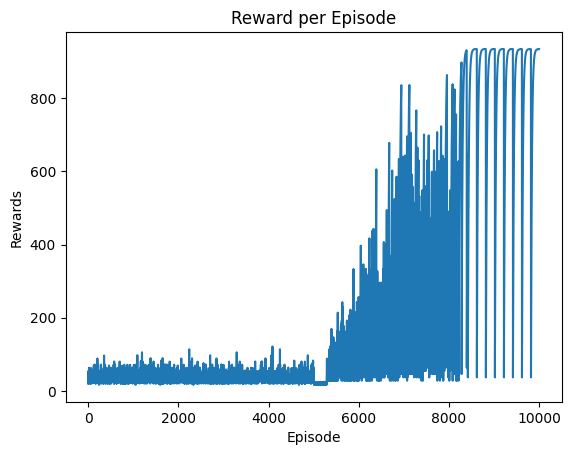

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def step_update(experience_buffer, batch_size, total_it, actor_eval, actor_target, critic_eval, critic_target, critic_optimizer,
                actor_optimizer, params):
    total_it[0] += 1
    policy_params = params.policy_params
    # sample mini-batch transitions
    state, action, next_state, reward, done = experience_buffer.sample(batch_size)
    with torch.no_grad():
        # select action according to policy and add clipped noise
        noise = (torch.normal(size=action.size(), mean=0., std=policy_params.policy_noise_std) * policy_params.policy_noise_scale).clamp(-policy_params.policy_noise_clip, policy_params.policy_noise_clip)
        next_action = (actor_target(next_state) + noise).clamp(-policy_params.max_action_td3, policy_params.max_action_td3)
        # clipped double Q-learning
        q_target_1, q_target_2 = critic_target(next_state, next_action)
        q_target = torch.min(q_target_1, q_target_2)
        y = reward + (1 - done) * policy_params.discount * q_target
    # update critic q_evaluate
    q_eval_1, q_eval_2 = critic_eval(state, action)
    critic_loss = F.mse_loss(q_eval_1, y) + F.mse_loss(q_eval_2, y)
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    # delayed policy update
    actor_loss = None
    if total_it[0] % policy_params.policy_freq == 0:
        # gradient ascent for actor policy DPG objective function J
        actor_loss = -critic_eval.q1(state, actor_eval(state)).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        # soft update: critic q_target
        for param_eval, param_target in zip(critic_eval.parameters(), critic_target.parameters()):
            param_target.data.copy_(policy_params.tau * param_eval.data + (1 - policy_params.tau) * param_target.data)
        for param_eval, param_target in zip(actor_eval.parameters(), actor_target.parameters()):
            param_target.data.copy_(policy_params.tau * param_eval.data + (1 - policy_params.tau) * param_target.data)
    return y, critic_loss, actor_loss


def train(params):
    # Initialize
    policy_params = params.policy_params
    env = get_env(params.env_name)
    video_log_trigger = LoggerTrigger(start_ind=policy_params.start_timestep)
    experience_buffer = ExperienceBufferTD3(policy_params.max_timestep, params.state_dim_td3, params.action_dim_td3, params.use_cuda)
    actor_eval = ActorTD3(params.state_dim_td3, params.action_dim_td3, policy_params.max_action_td3).to(device)
    actor_target = copy.deepcopy(actor_eval)
    actor_optimizer = torch.optim.Adam(actor_eval.parameters(), lr=policy_params.lr_td3)
    critic_eval = CriticTD3(params.state_dim_td3, params.action_dim_td3).to(device)
    critic_target = copy.deepcopy(critic_eval)
    critic_optimizer = torch.optim.Adam(critic_eval.parameters(), lr=policy_params.lr_td3)

    # Set Seed
    env.seed(policy_params.seed)
    torch.manual_seed(policy_params.seed)
    np.random.seed(policy_params.seed)

    # Training Loop
    print_cmd_hint(params, "start_train")
    state, done = env.reset(), False
    episode_reward, episode_timestep, episode_num = 0, 0, 0
    total_it = [0]
    ep_rewards = []
    for t in range(policy_params.max_timestep):
        episode_timestep += 1
        # >>> select action: epsilon-greedy variant?
        if t < policy_params.start_timestep:
            action = env.action_space.sample()
        else:
            # target policy smoothing regularization
            max_action = policy_params.max_action_td3
            action = (actor_eval(torch.Tensor(state).to(device)).detach().cpu()
                      + np.random.normal(loc=0, scale=max_action*policy_params.expl_noise_std_scale,
                                         size=params.action_dim_td3).astype(np.float32)).clamp(-max_action, max_action)
        # observe
        next_state, reward, done, info = env.step(action)
        # store transition tuple
        experience_buffer.add(state, action, reward, next_state, done)
        # update episode logger
        state = next_state
        episode_reward = reward + episode_reward * policy_params.discount
        # TD step update
        ep_rewards.append(episode_reward)
        if t >= policy_params.start_timestep:
            target_q, critic_loss, actor_loss = \
                step_update(experience_buffer, policy_params.batch_size, total_it, actor_eval, actor_target, critic_eval,
                            critic_target, critic_optimizer, actor_optimizer, params)
            wandb.log({'target_q': float(torch.mean(target_q).squeeze())}, step=t-policy_params.start_timestep)
            wandb.log({'critic_loss': float(torch.mean(critic_loss).squeeze())}, step=t-policy_params.start_timestep)
            if actor_loss is not None: wandb.log({'actor_loss': float(torch.mean(actor_loss).squeeze())}, step=t-policy_params.start_timestep)
        # start new episode
        if done:
            # record loggers
            episode_num += 1
            print(f"    > Total T: {t + 1} Episode Num: {episode_num + 1} Episode T: {episode_timestep} Reward: {episode_reward:.3f}")
            if t >= policy_params.start_timestep:
                wandb.log({'episode reward': episode_reward}, step=t-policy_params.start_timestep)
            # reset episode
            state, done = env.reset(), False
            episode_reward, episode_timestep = 0, 0
        # log video
        if params.save_video and video_log_trigger.good2log(t, params.video_interval): log_video(params.env_name, actor_target)
    print_cmd_hint(params, "end_train")
    for i in range(3):
        log_video(params.env_name, actor_target)
    plotQuantity(average_steps(ep_rewards,5),params.env_name)


"""
Quick Test
"""
if __name__ == "__main__":
    env_name = "InvertedDoublePendulum-v2"
    env = get_env(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    policy_params = ParamDict(
        seed=0,
        policy_noise_std=0.1,
        policy_noise_scale=0.2,
        expl_noise_std_scale=0.1,
        policy_noise_clip=0.5,
        max_action_td3=max_action,
        discount=0.99,
        policy_freq=2,
        tau=5e-3,
        lr_td3=3e-4,
        max_timestep=int(5e4),
        start_timestep=int(25e3),
        batch_size=100
    )
    params = ParamDict(
        policy_params=policy_params,
        env_name=env_name,
        state_dim_td3=state_dim,
        action_dim_td3=action_dim,
        save_video=True,
        video_interval=int(5e3),
        use_cuda=False
    )
    wandb.init(project="hiro-new")
    train(params=params)

  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))



actor_loss,███▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▁▁▁▂
critic_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁
episode reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▂▄▃▅▆█
target_q,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▃▄▄▄▅▅▅▅▅▅▆▅▆▆▆▆▇█▇█▇
actor_loss,-269.09622
critic_loss,39.34272
episode reward,934.57869
target_q,239.87187


Streaming output truncated to the last 5000 lines.
    > Total T: 771 Episode Num: 135 Episode T: 5 Reward: 4.901
    > Total T: 780 Episode Num: 136 Episode T: 9 Reward: 8.648
    > Total T: 784 Episode Num: 137 Episode T: 4 Reward: 3.940
    > Total T: 789 Episode Num: 138 Episode T: 5 Reward: 4.901
    > Total T: 793 Episode Num: 139 Episode T: 4 Reward: 3.940
    > Total T: 798 Episode Num: 140 Episode T: 5 Reward: 4.901
    > Total T: 805 Episode Num: 141 Episode T: 7 Reward: 6.793
    > Total T: 808 Episode Num: 142 Episode T: 3 Reward: 2.970
    > Total T: 815 Episode Num: 143 Episode T: 7 Reward: 6.793
    > Total T: 818 Episode Num: 144 Episode T: 3 Reward: 2.970
    > Total T: 824 Episode Num: 145 Episode T: 6 Reward: 5.852
    > Total T: 829 Episode Num: 146 Episode T: 5 Reward: 4.901
    > Total T: 837 Episode Num: 147 Episode T: 8 Reward: 7.726
    > Total T: 844 Episode Num: 148 Episode T: 7 Reward: 6.793
    > Total T: 849 Episode Num: 149 Episode T: 5 Reward: 4.901
    

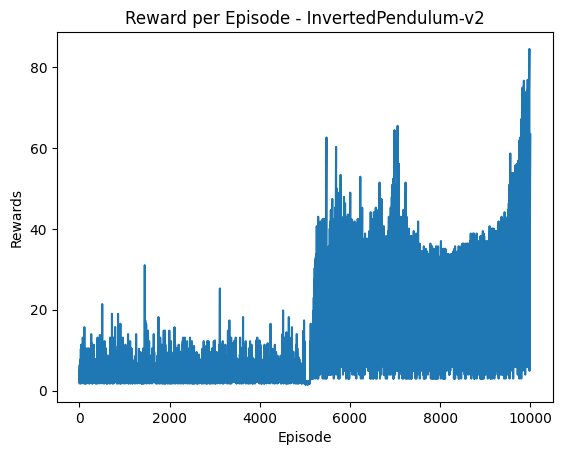

actor_loss,███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁
critic_loss,▁▁▁▂▂▁▂▂▂▂▄▅▂▂▅▃▃▃▃▄▂▅▂▇▆▃▅▂▆▇█▄▆▆▆▄▅▄▃▆
episode reward,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▅▆▅▇▆▆▆▅▆▆▆▆▆▅▅▅▅▅▅▅▆▆▆▆▆█
target_q,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▅▆▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇███▇█
actor_loss,-35.82977
critic_loss,3.49975
episode reward,85.33365
target_q,33.21711


Streaming output truncated to the last 5000 lines.
    > Total T: 355 Episode Num: 59 Episode T: 6 Reward: 53.389
    > Total T: 359 Episode Num: 60 Episode T: 4 Reward: 35.435
    > Total T: 363 Episode Num: 61 Episode T: 4 Reward: 35.542
    > Total T: 371 Episode Num: 62 Episode T: 8 Reward: 70.406
    > Total T: 377 Episode Num: 63 Episode T: 6 Reward: 53.219
    > Total T: 382 Episode Num: 64 Episode T: 5 Reward: 44.094
    > Total T: 387 Episode Num: 65 Episode T: 5 Reward: 44.647
    > Total T: 392 Episode Num: 66 Episode T: 5 Reward: 44.232
    > Total T: 397 Episode Num: 67 Episode T: 5 Reward: 44.064
    > Total T: 401 Episode Num: 68 Episode T: 4 Reward: 35.335
    > Total T: 409 Episode Num: 69 Episode T: 8 Reward: 70.668
    > Total T: 414 Episode Num: 70 Episode T: 5 Reward: 44.191
    > Total T: 418 Episode Num: 71 Episode T: 4 Reward: 34.974
    > Total T: 423 Episode Num: 72 Episode T: 5 Reward: 44.585
    > Total T: 428 Episode Num: 73 Episode T: 5 Reward: 44.144
    

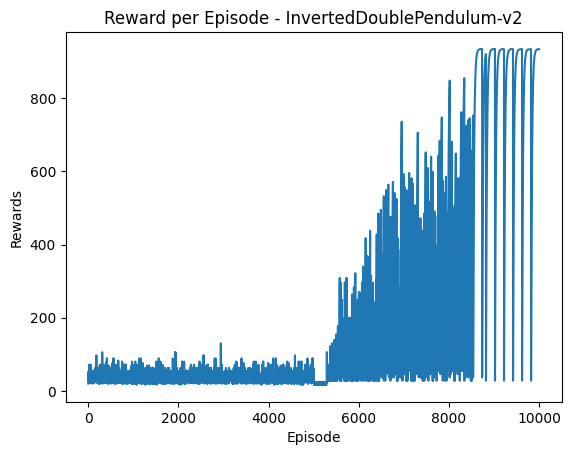

actor_loss,███▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▅▄▅▅▄▄▄▃▃▄▃▃▃▃▃▂▂▁▂▁▁
critic_loss,▁▁▂▁▂▁▃▁▂▂▂▂▃▂▂▂▃▃▂▆▂▂▄▄▃▃▅▄▃▆▄▃▄▄█▅▅▅▄▃
episode reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▄▂▂▂▂▃▄▂▃▆▅▅▅▄█
target_q,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▅▄▅▅▅▅▅▆▆▆▆▇█▇██
actor_loss,-267.28516
critic_loss,26.01517
episode reward,934.3776
target_q,236.54129




Start Train: Hopper-v2
    > Total T: 11 Episode Num: 2 Episode T: 11 Reward: 7.408
    > Total T: 50 Episode Num: 3 Episode T: 39 Reward: 29.840
    > Total T: 61 Episode Num: 4 Episode T: 11 Reward: 7.386
    > Total T: 89 Episode Num: 5 Episode T: 28 Reward: 8.332
    > Total T: 106 Episode Num: 6 Episode T: 17 Reward: 10.944
    > Total T: 123 Episode Num: 7 Episode T: 17 Reward: 8.662
    > Total T: 173 Episode Num: 8 Episode T: 50 Reward: 29.930
    > Total T: 190 Episode Num: 9 Episode T: 17 Reward: 12.210
    > Total T: 202 Episode Num: 10 Episode T: 12 Reward: 8.622
    > Total T: 239 Episode Num: 11 Episode T: 37 Reward: 32.479
    > Total T: 263 Episode Num: 12 Episode T: 24 Reward: 24.100
    > Total T: 287 Episode Num: 13 Episode T: 24 Reward: 21.977
    > Total T: 302 Episode Num: 14 Episode T: 15 Reward: 5.211
    > Total T: 327 Episode Num: 15 Episode T: 25 Reward: 11.110
    > Total T: 352 Episode Num: 16 Episode T: 25 Reward: 18.758
    > Total T: 374 Episode Num: 1

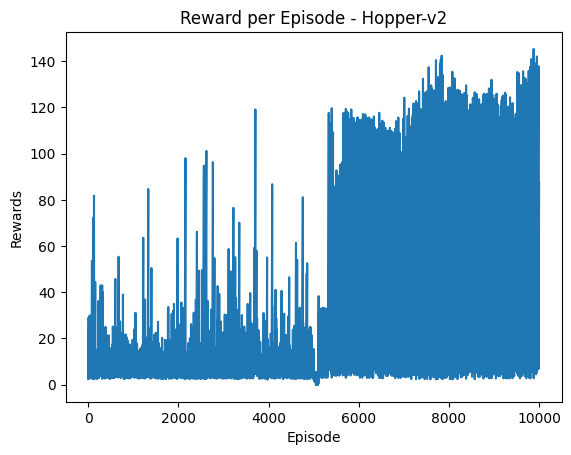

actor_loss,█████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
critic_loss,▁▁▁▁▁▁▁▂▂▁▂▂▂▁▂▃▂▂▅▂▄▃▂▆▂▁▄▃▃▃▃▃▃▇▅▁▅▄█▅
episode reward,▁▁▁▁▁▃▃▃▃▃▇▅▅▇▇▇▇▇▇▇▇▆▇▇█▇█▇█▇▇▇▇▇▇▇▇▇██
target_q,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
actor_loss,-103.20085
critic_loss,13.94168
episode reward,142.33096
target_q,100.35133




Start Train: Humanoid-v2
    > Total T: 20 Episode Num: 2 Episode T: 20 Reward: 91.677
    > Total T: 39 Episode Num: 3 Episode T: 19 Reward: 86.057
    > Total T: 62 Episode Num: 4 Episode T: 23 Reward: 106.043
    > Total T: 82 Episode Num: 5 Episode T: 20 Reward: 91.679
    > Total T: 101 Episode Num: 6 Episode T: 19 Reward: 87.109
    > Total T: 128 Episode Num: 7 Episode T: 27 Reward: 121.642
    > Total T: 162 Episode Num: 8 Episode T: 34 Reward: 145.892
    > Total T: 184 Episode Num: 9 Episode T: 22 Reward: 101.623
    > Total T: 214 Episode Num: 10 Episode T: 30 Reward: 128.476
    > Total T: 245 Episode Num: 11 Episode T: 31 Reward: 135.175
    > Total T: 263 Episode Num: 12 Episode T: 18 Reward: 81.923
    > Total T: 288 Episode Num: 13 Episode T: 25 Reward: 114.335
    > Total T: 316 Episode Num: 14 Episode T: 28 Reward: 130.410
    > Total T: 338 Episode Num: 15 Episode T: 22 Reward: 99.340
    > Total T: 356 Episode Num: 16 Episode T: 18 Reward: 80.961
    > Total T: 37

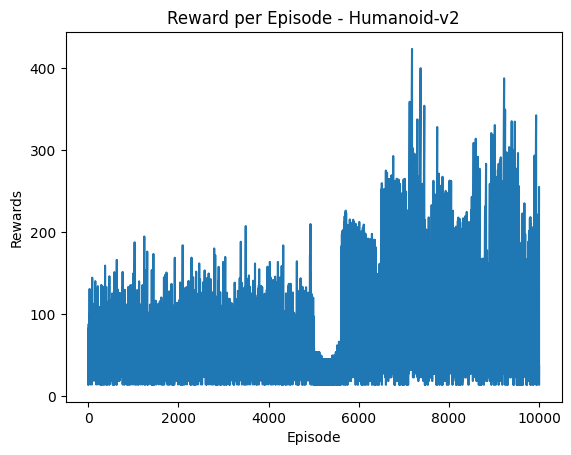

actor_loss,████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
critic_loss,▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▃▂▂▃█▃▃▃▆▄▃▃▄▅▄▃▃▃▆▄▄
episode reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▄▄▅▄▄▃▆▆▅▅▄▄▅▄▅▄▇▃▇█▅▅▅▃
target_q,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇████
actor_loss,-228.38574
critic_loss,186.61313
episode reward,263.27844
target_q,215.74638




Start Train: Ant-v2
    > Total T: 22 Episode Num: 2 Episode T: 22 Reward: -13.394
    > Total T: 47 Episode Num: 3 Episode T: 25 Reward: -3.446
    > Total T: 103 Episode Num: 4 Episode T: 56 Reward: -21.915
    > Total T: 408 Episode Num: 5 Episode T: 305 Reward: -20.128
    > Total T: 1408 Episode Num: 6 Episode T: 1000 Reward: -30.389
    > Total T: 1438 Episode Num: 7 Episode T: 30 Reward: -30.749
    > Total T: 2438 Episode Num: 8 Episode T: 1000 Reward: -28.649
    > Total T: 2514 Episode Num: 9 Episode T: 76 Reward: -21.323
    > Total T: 2642 Episode Num: 10 Episode T: 128 Reward: -62.048
    > Total T: 2744 Episode Num: 11 Episode T: 102 Reward: 28.036
    > Total T: 2878 Episode Num: 12 Episode T: 134 Reward: -39.358
    > Total T: 2991 Episode Num: 13 Episode T: 113 Reward: -69.243
    > Total T: 3006 Episode Num: 14 Episode T: 15 Reward: -2.827
    > Total T: 4006 Episode Num: 15 Episode T: 1000 Reward: -39.762
    > Total T: 4115 Episode Num: 16 Episode T: 109 Reward: 2

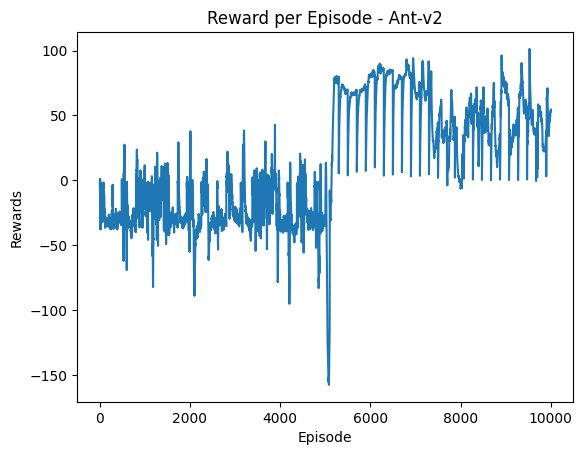

actor_loss,█████▇▇▇▇▆▆▆▆▅▅▅▄▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁
critic_loss,▁▁▂▂▂▄▂▂▃▃▃▃▄▄▄▇▅▃▅▄▇▇▄▄▄▆▅▆▆▆▅▄█▅▄▆▅▅▆▅
episode reward,▁█▇▇████████▇▆▆▆▇▇▆▆▇▇▇▆▇▆
target_q,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇██▇██
actor_loss,-33.57036
critic_loss,4.80445
episode reward,39.12819
target_q,31.64635




Start Train: Reacher-v2
    > Total T: 50 Episode Num: 2 Episode T: 50 Reward: -38.021
    > Total T: 100 Episode Num: 3 Episode T: 50 Reward: -28.677
    > Total T: 150 Episode Num: 4 Episode T: 50 Reward: -31.658
    > Total T: 200 Episode Num: 5 Episode T: 50 Reward: -35.149
    > Total T: 250 Episode Num: 6 Episode T: 50 Reward: -34.914
    > Total T: 300 Episode Num: 7 Episode T: 50 Reward: -39.480
    > Total T: 350 Episode Num: 8 Episode T: 50 Reward: -39.277
    > Total T: 400 Episode Num: 9 Episode T: 50 Reward: -30.404
    > Total T: 450 Episode Num: 10 Episode T: 50 Reward: -37.403
    > Total T: 500 Episode Num: 11 Episode T: 50 Reward: -35.340
    > Total T: 550 Episode Num: 12 Episode T: 50 Reward: -31.210
    > Total T: 600 Episode Num: 13 Episode T: 50 Reward: -34.046
    > Total T: 650 Episode Num: 14 Episode T: 50 Reward: -37.928
    > Total T: 700 Episode Num: 15 Episode T: 50 Reward: -34.683
    > Total T: 750 Episode Num: 16 Episode T: 50 Reward: -31.777
    > To

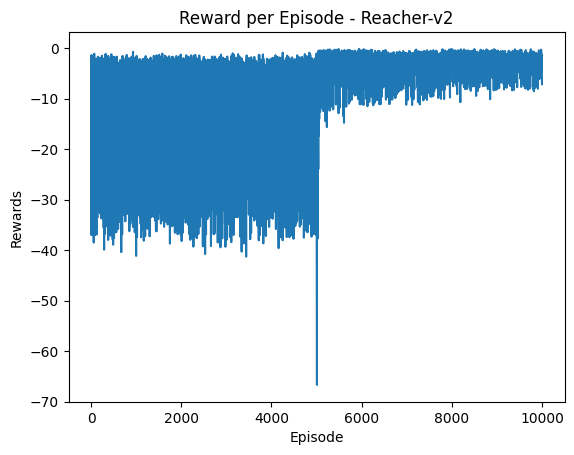

actor_loss,▂▁▁▁▂▂▃▃▄▄▄▅▅▅▆▆▅▆▅▆▆▇▇▇▇▇▇▇▇▇▆▇▆▇█▇▇▇▇▆
critic_loss,▄▁▂▁▁▂▁▂▃▂▂▂▁▂▁▄▁▃▃▆▄▂▃▄▁▁▂▂▃▃█▁▃▂▃▃▅▂▂▄
episode reward,▁▆▇▇▇▇▇▆▅▆▆▇▆▆█▇▆▇▆▆▆▇▇▆█▇▇▇█▆▇█▇▇██▇▇▇▇
target_q,█▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▃▂▃▂▁▃▃▂▂▃
actor_loss,3.03214
critic_loss,0.19573
episode reward,-7.38105
target_q,-3.54669




Start Train: HalfCheetah-v2
    > Total T: 1000 Episode Num: 2 Episode T: 1000 Reward: -29.173
    > Total T: 2000 Episode Num: 3 Episode T: 1000 Reward: -19.330
    > Total T: 3000 Episode Num: 4 Episode T: 1000 Reward: -63.653
    > Total T: 4000 Episode Num: 5 Episode T: 1000 Reward: -35.248
    > Total T: 5000 Episode Num: 6 Episode T: 1000 Reward: -19.456
    > Total T: 6000 Episode Num: 7 Episode T: 1000 Reward: -55.021
    > Total T: 7000 Episode Num: 8 Episode T: 1000 Reward: -22.683
    > Total T: 8000 Episode Num: 9 Episode T: 1000 Reward: -23.818
    > Total T: 9000 Episode Num: 10 Episode T: 1000 Reward: -22.973
    > Total T: 10000 Episode Num: 11 Episode T: 1000 Reward: -25.393
    > Total T: 11000 Episode Num: 12 Episode T: 1000 Reward: -52.704
    > Total T: 12000 Episode Num: 13 Episode T: 1000 Reward: -24.637
    > Total T: 13000 Episode Num: 14 Episode T: 1000 Reward: -19.517
    > Total T: 14000 Episode Num: 15 Episode T: 1000 Reward: -20.675
    > Total T: 15000 

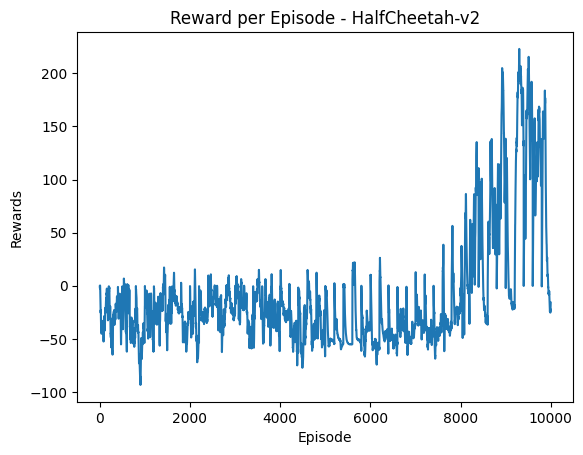

actor_loss,███▇▇▇▇▇█▇▇▇▇▆▇▆▆▆▅▅▆▆▅▆▄▅▃▅▅▅▅▄▅▃▅▃▂▁▁▃
critic_loss,▁▁▂▁▂▂▂▃▃▄▂▃▃▃▂▄▄▄▂▄▃▄▅▆▅▅▄▅▆▃▄▆▆▅▆▆▇▆█▆
episode reward,▁▁▁▁▂▁▁▁▂▂▂▁▂▂▂▂▇▂▆█▂███▃
target_q,▁▁▁▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▄▄▃▃▄▃▅▄▆▄▅▄▄▆▄▆▄▆▇██▆
actor_loss,-12.8304
critic_loss,4.12751
episode reward,-15.8741
target_q,11.8943




Start Train: Walker2d-v2
    > Total T: 16 Episode Num: 2 Episode T: 16 Reward: -6.444
    > Total T: 30 Episode Num: 3 Episode T: 14 Reward: 4.049
    > Total T: 62 Episode Num: 4 Episode T: 32 Reward: -6.684
    > Total T: 82 Episode Num: 5 Episode T: 20 Reward: 2.816
    > Total T: 95 Episode Num: 6 Episode T: 13 Reward: -1.473
    > Total T: 103 Episode Num: 7 Episode T: 8 Reward: -2.396
    > Total T: 123 Episode Num: 8 Episode T: 20 Reward: 5.852
    > Total T: 151 Episode Num: 9 Episode T: 28 Reward: -3.341
    > Total T: 167 Episode Num: 10 Episode T: 16 Reward: 4.241
    > Total T: 209 Episode Num: 11 Episode T: 42 Reward: 7.098
    > Total T: 223 Episode Num: 12 Episode T: 14 Reward: 3.504
    > Total T: 234 Episode Num: 13 Episode T: 11 Reward: -0.472
    > Total T: 249 Episode Num: 14 Episode T: 15 Reward: -5.563
    > Total T: 261 Episode Num: 15 Episode T: 12 Reward: -2.158
    > Total T: 274 Episode Num: 16 Episode T: 13 Reward: -1.656
    > Total T: 289 Episode Num: 1

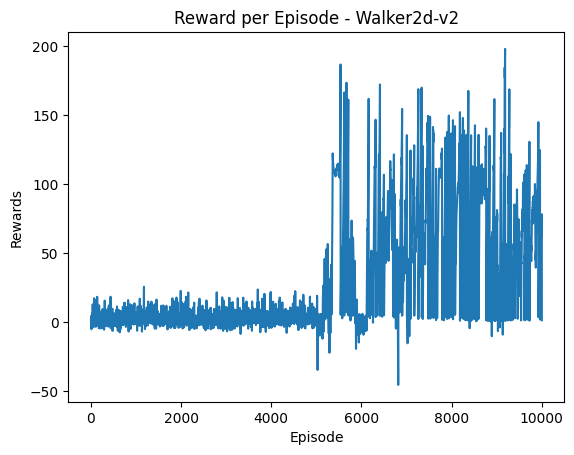

In [ ]:
envnames_mujoco = ['InvertedPendulum-v2', 'InvertedDoublePendulum-v2', 'Hopper-v2',
                   'Humanoid-v2', 'Ant-v2', 'Reacher-v2', 'HalfCheetah-v2', 'Walker2d-v2']
for env_name in envnames_mujoco:
    env = get_env(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    policy_params = ParamDict(
        seed=0,
        policy_noise_std=0.1,
        policy_noise_scale=0.2,
        expl_noise_std_scale=0.1,
        policy_noise_clip=0.5,
        max_action_td3=max_action,
        discount=0.99,
        policy_freq=2,
        tau=5e-3,
        lr_td3=3e-4,
        max_timestep=int(5e4),
        start_timestep=int(25e3),
        batch_size=100
    )
    params = ParamDict(
        policy_params=policy_params,
        env_name=env_name,
        state_dim_td3=state_dim,
        action_dim_td3=action_dim,
        save_video=True,
        video_interval=int(5e3),
        use_cuda=False
    )
    wandb.init(project="hiro-new")
    train(params=params)

##HIRO

In [ ]:
"""
HIRO training process
"""
import os
import datetime
from torch import Tensor
import copy
import torch
from torch.nn import functional
# from utils import get_env, get_target_position, log_video_hrl, ParamDict, LoggerTrigger, TimeLogger, print_cmd_hint
# from network import ActorLow, ActorHigh, CriticLow, CriticHigh
# from experience_buffer import ExperienceBufferLow, ExperienceBufferHigh


def save_evaluate_utils(step, actor_l, actor_h, params, file_path=None, file_name=None):
    if file_name is None:
        time = datetime.datetime.now()
        file_name = "evalutils-hiro-{}_{}-it({})-[{}].tar".format(params.env_name.lower(), params.prefix, step, time)
    if file_path is None:
        file_path = os.path.join(".", "save", "model", file_name)
    print("\n    > saving evaluation utils...")
    torch.save({
        'step': step,
        'actor_l': actor_l.state_dict(),
        'actor_h': actor_h.state_dict(),
    }, file_path)
    print("    > saved evaluation utils to: {}\n".format(file_path))


def save_checkpoint(step, actor_l, critic_l, actor_optimizer_l, critic_optimizer_l, exp_l, actor_h, critic_h, actor_optimizer_h, critic_optimizer_h, exp_h, logger, params, file_path=None, file_name=None):
    if file_name is None:
        time = datetime.datetime.now()
        file_name = "checkpoint-hiro-{}_{}-it({})-[{}].tar".format(params.env_name.lower(), params.prefix, step, time)
    if file_path is None:
        file_path = os.path.join(".", "save", "model", file_name)
    print("\n    > saving training checkpoint...")
    torch.save({
        'step': step,
        'params': params,
        'logger': logger,
        'actor_l': actor_l.state_dict(),
        'critic_l': critic_l.state_dict(),
        'actor_optimizer_l': actor_optimizer_l.state_dict(),
        'critic_optimizer_l': critic_optimizer_l.state_dict(),
        'exp_l': exp_l,
        'actor_h': actor_h.state_dict(),
        'critic_h': critic_h.state_dict(),
        'actor_optimizer_h': actor_optimizer_h.state_dict(),
        'critic_optimizer_h': critic_optimizer_h.state_dict(),
        'exp_h': exp_h
    }, file_path)
    print("    > saved checkpoint to: {}\n".format(file_path))


def load_checkpoint(file_name):
    try:
        # load checkpoint file
        print("\n    > loading training checkpoint...")
        file_path = os.path.join(".", "save", "model", file_name)
        checkpoint = torch.load(file_path)
        print("\n    > checkpoint file loaded! parsing data...")
        params = checkpoint['params']
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if params.use_cuda else "cpu"
        # load utils
        policy_params = params.policy_params
        state_dim = params.state_dim
        goal_dim = params.goal_dim
        action_dim = params.action_dim
        max_action = policy_params.max_action
        max_goal = policy_params.max_goal
        # initialize rl components
        actor_eval_l = ActorLow(state_dim, goal_dim, action_dim, max_action).to(device)
        actor_optimizer_l = torch.optim.Adam(actor_eval_l.parameters(), lr=policy_params.actor_lr)
        critic_eval_l = CriticLow(state_dim, goal_dim, action_dim).to(device)
        critic_optimizer_l = torch.optim.Adam(critic_eval_l.parameters(), lr=policy_params.critic_lr)
        actor_eval_h = ActorHigh(state_dim, goal_dim, max_goal, device).to(device)
        actor_optimizer_h = torch.optim.Adam(actor_eval_h.parameters(), lr=policy_params.actor_lr)
        critic_eval_h = CriticHigh(state_dim, goal_dim).to(device)
        critic_optimizer_h = torch.optim.Adam(critic_eval_h.parameters(), lr=policy_params.critic_lr)
        # unpack checkpoint object
        step = checkpoint['step'] + 1
        logger = checkpoint['logger']
        #
        actor_eval_l.load_state_dict(checkpoint['actor_l'])
        critic_eval_l.load_state_dict(checkpoint['critic_l'])
        actor_optimizer_l.load_state_dict((checkpoint['actor_optimizer_l']))
        critic_optimizer_l.load_state_dict(checkpoint['critic_optimizer_l'])
        experience_buffer_l = checkpoint['exp_l']
        #
        actor_eval_h.load_state_dict(checkpoint['actor_h'])
        critic_eval_h.load_state_dict(checkpoint['critic_h'])
        actor_optimizer_h.load_state_dict((checkpoint['actor_optimizer_h']))
        critic_optimizer_h.load_state_dict(checkpoint['critic_optimizer_h'])
        experience_buffer_h = checkpoint['exp_h']
        #
        actor_target_l = copy.deepcopy(actor_eval_l).to(device)
        critic_target_l = copy.deepcopy(critic_eval_l).to(device)
        actor_target_h = copy.deepcopy(actor_eval_h).to(device)
        critic_target_h = copy.deepcopy(critic_eval_h).to(device)
        #
        actor_eval_l.train(), actor_target_l.train(), critic_eval_l.train(), critic_target_l.train()
        actor_eval_h.train(), actor_target_h.train(), critic_eval_h.train(), critic_target_h.train()
        print("    > checkpoint resume success!")
    except Exception as e:
        print(e)
    return [step, params, device, logger,
            actor_eval_l, actor_target_l, critic_eval_l, critic_target_l, actor_optimizer_l, critic_optimizer_l, experience_buffer_l,
            actor_eval_h, actor_target_h, critic_eval_h, critic_target_h, actor_optimizer_h, critic_optimizer_h, experience_buffer_h]


def initialize_params(params, device):
    policy_params = params.policy_params
    env_name = params.env_name
    max_goal = Tensor(policy_params.max_goal).to(device)
    action_dim = params.action_dim
    goal_dim = params.goal_dim
    max_action = policy_params.max_action
    expl_noise_std_l = policy_params.expl_noise_std_l
    expl_noise_std_h = policy_params.expl_noise_std_h
    c = policy_params.c
    episode_len = policy_params.episode_len
    max_timestep = policy_params.max_timestep
    start_timestep = policy_params.start_timestep
    batch_size = policy_params.batch_size
    log_interval = params.log_interval
    checkpoint_interval = params.checkpoint_interval
    evaluation_interval = params.evaluation_interval
    save_video = params.save_video
    video_interval = params.video_interval
    env = get_env(params.env_name)
    video_log_trigger = LoggerTrigger(start_ind=policy_params.start_timestep)
    state_print_trigger = LoggerTrigger(start_ind=policy_params.start_timestep)
    checkpoint_logger = LoggerTrigger(start_ind=policy_params.start_timestep, first_log=False)
    evalutil_logger = LoggerTrigger(start_ind=policy_params.start_timestep, first_log=False)
    time_logger = TimeLogger()
    return [policy_params, env_name, max_goal, action_dim, goal_dim, max_action, expl_noise_std_l, expl_noise_std_h,
            c, episode_len, max_timestep, start_timestep, batch_size,
            log_interval, checkpoint_interval, evaluation_interval, save_video, video_interval, env, video_log_trigger, state_print_trigger, checkpoint_logger, evalutil_logger, time_logger]


def initialize_params_checkpoint(params, device):
    policy_params = params.policy_params
    env_name = params.env_name
    max_goal = Tensor(policy_params.max_goal).to(device)
    action_dim = params.action_dim
    goal_dim = params.goal_dim
    max_action = policy_params.max_action
    expl_noise_std_l = policy_params.expl_noise_std_l
    expl_noise_std_h = policy_params.expl_noise_std_h
    c = policy_params.c
    episode_len = policy_params.episode_len
    max_timestep = policy_params.max_timestep
    start_timestep = policy_params.start_timestep
    batch_size = policy_params.batch_size
    log_interval = params.log_interval
    checkpoint_interval = params.checkpoint_interval
    save_video = params.save_video
    video_interval = params.video_interval
    env = get_env(params.env_name)
    return [policy_params, env_name, max_goal, action_dim, goal_dim, max_action, expl_noise_std_l, expl_noise_std_h,
            c, episode_len, max_timestep, start_timestep, batch_size,
            log_interval, checkpoint_interval, save_video, video_interval, env]


def record_logger(args, option, step):
    if option == "inter_loss":
        target_q_l, critic_loss_l, actor_loss_l, target_q_h, critic_loss_h, actor_loss_h = args[:]
        if target_q_l is not None: wandb.log({'target_q low': torch.mean(target_q_l).squeeze()}, step=step)
        if critic_loss_l is not None: wandb.log({'critic_loss low': torch.mean(critic_loss_l).squeeze()}, step=step)
        if actor_loss_l is not None: wandb.log({'actor_loss low': torch.mean(actor_loss_l).squeeze()}, step=step)
        if target_q_h is not None: wandb.log({'target_q high': torch.mean(target_q_h).squeeze()}, step=step)
        if critic_loss_h is not None: wandb.log({'critic_loss high': torch.mean(critic_loss_h).squeeze()}, step=step)
        if actor_loss_h is not None: wandb.log({'actor_loss high': torch.mean(actor_loss_h).squeeze()}, step=step)
    elif option == "reward":
        episode_reward_l, episode_reward_h = args[:]
        wandb.log({'episode reward low': episode_reward_l}, step=step)
        wandb.log({'episode reward high': episode_reward_h}, step=step)
    elif option == "success_rate":
        success_rate = args[0]
        wandb.log({'success rate': success_rate}, step=step)


def create_rl_components(params, device):
    # function local utils
    policy_params = params.policy_params
    state_dim, goal_dim, action_dim = params.state_dim, params.goal_dim, params.action_dim
    max_goal = Tensor(policy_params.max_goal)
    # low-level
    step, episode_num_h = 0, 0
    actor_eval_l = ActorLow(state_dim, goal_dim, action_dim, policy_params.max_action).to(device)
    actor_target_l = copy.deepcopy(actor_eval_l).to(device)
    actor_optimizer_l = torch.optim.Adam(actor_eval_l.parameters(), lr=policy_params.actor_lr)
    critic_eval_l = CriticLow(state_dim, goal_dim, action_dim).to(device)
    critic_target_l = copy.deepcopy(critic_eval_l).to(device)
    critic_optimizer_l = torch.optim.Adam(critic_eval_l.parameters(), lr=policy_params.critic_lr)
    experience_buffer_l = ExperienceBufferLow(policy_params.max_timestep, state_dim, goal_dim, action_dim, params.use_cuda)
    # high-level
    actor_eval_h = ActorHigh(state_dim, goal_dim, max_goal, device).to(device)
    actor_target_h = copy.deepcopy(actor_eval_h).to(device)
    actor_optimizer_h = torch.optim.Adam(actor_eval_h.parameters(), lr=policy_params.actor_lr)
    critic_eval_h = CriticHigh(state_dim, goal_dim).to(device)
    critic_target_h = copy.deepcopy(critic_eval_h).to(device)
    critic_optimizer_h = torch.optim.Adam(critic_eval_h.parameters(), lr=policy_params.critic_lr)
    experience_buffer_h = ExperienceBufferHigh(int(policy_params.max_timestep / policy_params.c) + 1, state_dim, goal_dim, params.use_cuda)

    return [step, episode_num_h,
            actor_eval_l, actor_target_l, actor_optimizer_l, critic_eval_l, critic_target_l, critic_optimizer_l, experience_buffer_l,
            actor_eval_h, actor_target_h, actor_optimizer_h, critic_eval_h, critic_target_h, critic_optimizer_h, experience_buffer_h]


def h_function(state, goal, next_state, goal_dim):
    # return next goal
    return state[:goal_dim] + goal - next_state[:goal_dim]


def intrinsic_reward(state, goal, next_state):
    # low-level dense reward (L2 norm), provided by high-level policy
    return -torch.pow(sum(torch.pow(state + goal - next_state, 2)), 1 / 2)


def intrinsic_reward_simple(state, goal, next_state, goal_dim):
    # low-level dense reward (L2 norm), provided by high-level policy
    return -torch.pow(sum(torch.pow(state[:goal_dim] + goal - next_state[:4], 2)), 1 / 2)
    # return -torch.pow(sum(torch.pow(state[:goal_dim] + goal - next_state[:3], 2)), 1 / 2)

def dense_reward(state, goal_dim, target=Tensor([0, 19, 0.5])):
    device = state.device
    target = target.to(device)
    l2_norm = torch.pow(sum(torch.pow(state[:goal_dim] - target, 2)), 1 / 2)
    return -l2_norm


def done_judge_low(goal):
    # define low-level success: same as high-level success (L2 norm < 5, paper B.2.2)
    l2_norm = torch.pow(sum(torch.pow(goal, 2)), 1 / 2)
    # done = (l2_norm <= 5.)
    done = (l2_norm <= 1.5)
    return Tensor([done])


def success_judge(state, goal_dim, target=Tensor([0, 19, 0.5])):
    location = state[:goal_dim]
    l2_norm = torch.pow(sum(torch.pow(location - target, 2)), 1 / 2)
    done = (l2_norm <= 5.)
    return Tensor([done])


def off_policy_correction(actor, action_sequence, state_sequence, goal_dim, goal, end_state, max_goal, device):
    # initialize
    action_sequence = torch.stack(action_sequence).to(device)
    state_sequence = torch.stack(state_sequence).to(device)
    max_goal = max_goal.cpu()
    # prepare candidates
    mean = (end_state - state_sequence[0])[:goal_dim].cpu()
    std = 0.5 * max_goal
    candidates = [torch.min(torch.max(Tensor(np.random.normal(loc=mean, scale=std, size=goal_dim).astype(np.float32)), -max_goal), max_goal) for _ in range(8)]
    candidates.append(mean)
    candidates.append(goal.cpu())
    # select maximal
    candidates = torch.stack(candidates).to(device)
    surr_prob = [-functional.mse_loss(action_sequence, actor(state_sequence, state_sequence[0][:goal_dim] + candidate - state_sequence[:, :goal_dim])) for candidate in candidates]
    # index = int(np.argmax(surr_prob))
    index, value = max(enumerate(surr_prob), key=lambda x: x[1])
    updated = (index != 9)
    goal_hat = candidates[index]
    return goal_hat.cpu(), updated


def step_update_l(experience_buffer, batch_size, total_it, actor_eval, actor_target, critic_eval, critic_target, critic_optimizer, actor_optimizer, params):
    # initialize
    policy_params = params.policy_params
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if params.use_cuda else "cpu"
    total_it[0] += 1
    # sample mini-batch transitions
    state, goal, action, reward, next_state, next_goal, done = experience_buffer.sample(batch_size)
    with torch.no_grad():
        # select action according to policy and add clipped noise
        policy_noise = Tensor(np.random.normal(loc=0, scale=policy_params.policy_noise_std, size=params.action_dim).astype(np.float32) * policy_params.policy_noise_scale) \
            .clamp(-policy_params.policy_noise_clip, policy_params.policy_noise_clip).to(device)
        next_action = (actor_target(next_state, next_goal) + policy_noise).clamp(-policy_params.max_action, policy_params.max_action)
        # clipped double Q-learning
        q_target_1, q_target_2 = critic_target(next_state, next_goal, next_action)
        q_target = torch.min(q_target_1, q_target_2)
        y = policy_params.reward_scal_l * reward + (1 - done) * policy_params.discount * q_target
    # update critic q_evaluate
    q_eval_1, q_eval_2 = critic_eval(state, goal, action)
    critic_loss = functional.mse_loss(q_eval_1, y) + functional.mse_loss(q_eval_2, y)
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    # delayed policy update
    actor_loss = None
    if total_it[0] % policy_params.policy_freq == 0:
        # compute actor loss
        actor_loss = -critic_eval.q1(state, goal, actor_eval(state, goal)).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        # soft update: critic q_target
        for param_eval, param_target in zip(critic_eval.parameters(), critic_target.parameters()):
            param_target.data.copy_(policy_params.tau * param_eval.data + (1 - policy_params.tau) * param_target.data)
        for param_eval, param_target in zip(actor_eval.parameters(), actor_target.parameters()):
            param_target.data.copy_(policy_params.tau * param_eval.data + (1 - policy_params.tau) * param_target.data)
        actor_loss = actor_loss.detach()
    return y.detach(), critic_loss.detach(), actor_loss


def step_update_h(experience_buffer, batch_size, total_it, actor_eval, actor_target, critic_eval, critic_target, critic_optimizer, actor_optimizer, params):
    policy_params = params.policy_params
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if params.use_cuda else "cpu"
    max_goal = Tensor(policy_params.max_goal).to(device)
    # sample mini-batch transitions
    state_start, goal, reward, state_end, done = experience_buffer.sample(batch_size)
    with torch.no_grad():
        # select action according to policy and add clipped noise
        policy_noise = Tensor(np.random.normal(loc=0, scale=policy_params.policy_noise_std, size=params.goal_dim).astype(np.float32) * policy_params.policy_noise_scale) \
            .clamp(-policy_params.policy_noise_clip, policy_params.policy_noise_clip).to(device)
        next_goal = torch.min(torch.max(actor_target(state_end) + policy_noise, -max_goal), max_goal)
        # clipped double Q-learning
        q_target_1, q_target_2 = critic_target(state_end, next_goal)
        q_target = torch.min(q_target_1, q_target_2)
        y = policy_params.reward_scal_h * reward + (1 - done) * policy_params.discount * q_target
    # update critic q_evaluate
    q_eval_1, q_eval_2 = critic_eval(state_start, goal)
    critic_loss = functional.mse_loss(q_eval_1, y) + functional.mse_loss(q_eval_2, y)
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    # delayed policy updates
    actor_loss = None
    if int(total_it[0] / policy_params.c) % policy_params.policy_freq == 0:
        # compute actor loss
        actor_loss = -critic_eval.q1(state_start, actor_eval(state_start)).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        # soft update: critic q_target
        for param_eval, param_target in zip(critic_eval.parameters(), critic_target.parameters()):
            param_target.data.copy_(policy_params.tau * param_eval.data + (1 - policy_params.tau) * param_target.data)
        for param_eval, param_target in zip(actor_eval.parameters(), actor_target.parameters()):
            param_target.data.copy_(policy_params.tau * param_eval.data + (1 - policy_params.tau) * param_target.data)
        actor_loss = actor_loss.detach()
    return y.detach(), critic_loss.detach(), actor_loss


def evaluate(actor_l, actor_h, params, target_pos, device):
    policy_params = params.policy_params
    print("\n    > evaluating policies...")
    success_number = 0
    env = get_env(params.env_name)
    goal_dim = params.goal_dim
    for i in range(10):
        env.seed(policy_params.seed + i)
        for j in range(5):
            t = 0
            episode_len = policy_params.episode_len
            obs, done = Tensor(env.reset()).to(device), False
            goal = Tensor(torch.randn(goal_dim)).to(device)
            while not done and t < episode_len:
                t += 1
                action = actor_l(obs, goal).to(device)
                obs, _, _, _ = env.step(action.detach().cpu())
                obs = Tensor(obs).to(device)
                done = success_judge(obs, goal_dim, target_pos)
                goal = actor_h(obs)
            if done:
                success_number += 1
        print("        > evaluated {} episodes".format(i * 5 + j + 1))
    success_rate = success_number / 50
    print("    > finished evaluation, success rate: {}\n".format(success_rate))
    return success_rate


def train(params):
    # 1. Initialization
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if params.use_cuda else "cpu"
    if params.checkpoint is None:
        # > rl components
        [step, episode_num_h,
         actor_eval_l, actor_target_l, actor_optimizer_l, critic_eval_l, critic_target_l, critic_optimizer_l, experience_buffer_l,
         actor_eval_h, actor_target_h, actor_optimizer_h, critic_eval_h, critic_target_h, critic_optimizer_h, experience_buffer_h] = create_rl_components(params, device)
        # > running utils
        [policy_params, env_name, max_goal, action_dim, goal_dim, max_action, expl_noise_std_l, expl_noise_std_h,
         c, episode_len, max_timestep, start_timestep, batch_size,
         log_interval, checkpoint_interval, evaluation_interval, save_video, video_interval, env, video_log_trigger, state_print_trigger, checkpoint_logger, evalutil_logger, time_logger] = initialize_params(params, device)
    else:
        # > rl components
        prefix = params.prefix
        [step, params, device, [time_logger, state_print_trigger, video_log_trigger, checkpoint_logger, evalutil_logger, episode_num_h],
         actor_eval_l, actor_target_l, critic_eval_l, critic_target_l, actor_optimizer_l, critic_optimizer_l, experience_buffer_l,
         actor_eval_h, actor_target_h, critic_eval_h, critic_target_h, actor_optimizer_h, critic_optimizer_h, experience_buffer_h] = load_checkpoint(params.checkpoint)
        # > running utils
        [policy_params, env_name, max_goal, action_dim, goal_dim, max_action, expl_noise_std_l, expl_noise_std_h,
         c, episode_len, max_timestep, start_timestep, batch_size,
         log_interval, checkpoint_interval, evaluation_interval, save_video, video_interval, env] = initialize_params_checkpoint(params, device)
        params.prefix = prefix
    target_q_h, critic_loss_h, actor_loss_h = None, None, None
    target_pos = get_target_position(env_name).to(device)
    # 1.2 set seeds
    env.seed(policy_params.seed)
    torch.manual_seed(policy_params.seed)
    np.random.seed(policy_params.seed)

    # 2. Training Algorithm (TD3)
    # 2.1 initialize
    print_cmd_hint(params=params, location='start_train')
    time_logger.time_spent()
    total_it = [0]
    success_rate, episode_reward_l, episode_reward_h, episode_reward, episode_num_l, episode_timestep_l, episode_timestep_h = 0, 0, 0, 0, 0, 1, 1
    state = Tensor(env.reset()).to(device)
    goal = Tensor(torch.randn(goal_dim)).to(device)
    state_sequence, goal_sequence, action_sequence, intri_reward_sequence, reward_h_sequence = [], [], [], [], []
    # 2.2 training loop
    for t in range(step, max_timestep):
        # 2.2.1 sample action
        if t < start_timestep:
            action = env.action_space.sample()
        else:
            expl_noise_action = np.random.normal(loc=0, scale=expl_noise_std_l, size=action_dim).astype(np.float32)
            action = (actor_eval_l(state, goal).detach().cpu() + expl_noise_action).clamp(-max_action, max_action).squeeze()
        # 2.2.2 interact environment
        next_state, _, _, info = env.step(action)
        # 2.2.3 compute step arguments
        reward_h = dense_reward(state, goal_dim, target=target_pos)
        done_h = success_judge(state, goal_dim, target_pos)
        next_state, action, reward_h, done_h = Tensor(next_state).to(device), Tensor(action), Tensor([reward_h]), Tensor([done_h])
        intri_reward = intrinsic_reward_simple(state, goal, next_state, goal_dim)
        next_goal = h_function(state, goal, next_state, goal_dim)
        done_l = done_judge_low(goal)
        # 2.2.4 collect low-level experience
        experience_buffer_l.add(state, goal, action, intri_reward, next_state, next_goal, done_l)
        # 2.2.5 record segment arguments
        state_sequence.append(state)
        action_sequence.append(action)
        intri_reward_sequence.append(intri_reward)
        goal_sequence.append(goal)
        reward_h_sequence.append(reward_h)
        # 2.2.6 update low-level segment reward
        episode_reward_l += intri_reward
        episode_reward_h += reward_h
        episode_reward += reward_h
        if (t + 1) % c == 0 and t > 0:
            # 2.2.7 sample goal
            if t < start_timestep:
                next_goal = (torch.randn_like(goal) * max_goal)
                next_goal = torch.min(torch.max(next_goal, -max_goal), max_goal)
            else:
                expl_noise_goal = np.random.normal(loc=0, scale=expl_noise_std_h, size=goal_dim).astype(np.float32)
                next_goal = (actor_eval_h(next_state.to(device)).detach().cpu() + expl_noise_goal).squeeze().to(device)
                next_goal = torch.min(torch.max(next_goal, -max_goal), max_goal)
            # 2.2.8 collect high-level experience
            goal_hat, updated = off_policy_correction(actor_target_l, action_sequence, state_sequence, goal_dim, goal_sequence[0], next_state, max_goal, device)
            experience_buffer_h.add(state_sequence[0], goal_hat, episode_reward_h, next_state, done_h)
            # if state_print_trigger.good2log(t, 500): print_cmd_hint(params=[state_sequence, goal_sequence, action_sequence, intri_reward_sequence, updated, goal_hat, reward_h_sequence], location='training_state')
            # 2.2.9 reset segment arguments & log (reward)
            state_sequence, action_sequence, intri_reward_sequence, goal_sequence, reward_h_sequence = [], [], [], [], []
            print(f"    > Segment: Total T: {t + 1} Episode_L Num: {episode_num_l + 1} Episode_L T: {episode_timestep_l} Reward_L: {float(episode_reward_l):.3f} Reward_H: {float(episode_reward_h):.3f}")
            if t >= start_timestep: record_logger(args=[episode_reward_l, episode_reward_h], option='reward', step=t-start_timestep)
            episode_reward_l, episode_timestep_l = 0, 0
            episode_reward_h = 0
            episode_num_l += 1
        # 2.2.10 update observations
        state = next_state
        goal = next_goal

        # 2.2.11 update networks
        if t >= start_timestep:
            target_q_l, critic_loss_l, actor_loss_l = \
                step_update_l(experience_buffer_l, batch_size, total_it, actor_eval_l, actor_target_l, critic_eval_l, critic_target_l, critic_optimizer_l, actor_optimizer_l, params)
        if t >= start_timestep and (t + 1) % c == 0:
            target_q_h, critic_loss_h, actor_loss_h = \
                step_update_h(experience_buffer_h, batch_size, total_it, actor_eval_h, actor_target_h, critic_eval_h, critic_target_h, critic_optimizer_h, actor_optimizer_h, params)
        # 2.2.12 log training curve (inter_loss)
        if t >= start_timestep and t % log_interval == 0:
            record_logger(args=[target_q_l, critic_loss_l, actor_loss_l, target_q_h, critic_loss_h, actor_loss_h], option='inter_loss', step=t-start_timestep)
            record_logger([success_rate], 'success_rate', step=t - start_timestep)
        # 2.2.13 start new episode
        if episode_timestep_h >= episode_len:
            # > update loggers
            if t > start_timestep: episode_num_h += 1
            else: episode_num_h = 0
            print(f"    >>> Episode: Total T: {t + 1} Episode_H Num: {episode_num_h+1} Episode_H T: {episode_timestep_h} Reward_Episode: {float(episode_reward):.3f}\n")
            # > clear loggers
            episode_reward = 0
            state_sequence, action_sequence, intri_reward_sequence, goal_sequence, reward_h_sequence = [], [], [], [], []
            episode_reward_l, episode_timestep_l, episode_num_l = 0, 0, 0
            state, done_h = Tensor(env.reset()).to(device), Tensor([False])
            episode_reward_h, episode_timestep_h = 0, 0
        # 2.2.14 update training loop arguments
        episode_timestep_l += 1
        episode_timestep_h += 1
        # 2.2.15 save videos & checkpoints
        if save_video and video_log_trigger.good2log(t, video_interval):
            log_video_hrl(env_name, actor_target_l, actor_target_h, params)
            time_logger.sps(t)
            time_logger.time_spent()
            print("")
        if checkpoint_logger.good2log(t, checkpoint_interval):
            logger = [time_logger, state_print_trigger, video_log_trigger, checkpoint_logger, evalutil_logger, episode_num_h]
            save_checkpoint(t, actor_target_l, critic_target_l, actor_optimizer_l, critic_optimizer_l, experience_buffer_l,
                            actor_target_h, critic_target_h, actor_optimizer_h, critic_optimizer_h, experience_buffer_h,
                            logger, params)
        if t > start_timestep and evalutil_logger.good2log(t, evaluation_interval):
            success_rate = evaluate(actor_target_l, actor_target_h, params, target_pos, device)
    # 2.3 final log (episode videos)
    logger = [time_logger, state_print_trigger, video_log_trigger, checkpoint_logger, evalutil_logger, episode_num_h]
    save_checkpoint(max_timestep, actor_target_l, critic_target_l, actor_optimizer_l, critic_optimizer_l, experience_buffer_l,
                    actor_target_h, critic_target_h, actor_optimizer_h, critic_optimizer_h, experience_buffer_h,
                    logger, params)
    for i in range(3):
        log_video_hrl(env_name, actor_target_l, actor_target_h, params)
    print_cmd_hint(params=params, location='end_train')


if __name__ == "__main__":
    env_name = "InvertedPendulum-v2"
    env = get_env(env_name)
    state_dim = env.observation_space.shape[0]
    # goal_dim = 3
    goal_dim = state_dim
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    # max_goal = [10., 10., .5]
    # max_goal = [0., 0., 0., 0.]
    max_goal = [0.]*(state_dim)
    policy_params = ParamDict(
        seed=54321,
        c=10,
        policy_noise_scale=0.2,
        policy_noise_std=1.,
        expl_noise_std_l=1.,
        expl_noise_std_h=1.,
        policy_noise_clip=0.5,
        max_action=max_action,
        max_goal=max_goal,
        discount=0.99,
        policy_freq=1,
        tau=5e-3,
        actor_lr=1e-4,
        critic_lr=1e-3,
        reward_scal_l=1.,
        reward_scal_h=.1,
        episode_len=1000,
        max_timestep=int(3e6),
        start_timestep=int(300),
        batch_size=100
    )
    params = ParamDict(
        policy_params=policy_params,
        env_name=env_name,
        state_dim=state_dim,
        action_dim=action_dim,
        # goal_dim=3,
        goal_dim=goal_dim,
        video_interval=int(1e4),
        log_interval=5,
        checkpoint_interval=int(1e5),
        evaluation_interval=int(1e4),
        prefix="test_simple_origGoal_fixedIntriR_posER",
        save_video=True,
        use_cuda=True,
        # checkpoint="hiro-antpush_test_simple_origGoal_fixedIntriR_posER-it(2000000)-[2020-07-02 20:35:25.673267].tar"
        checkpoint=None
    )

    wandb.init(project="ziang-hiro-new")
    train(params=params)